In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
plt.show()
plt.rcParams["figure.figsize"] = [16, 9]

In [3]:
pair = 'BTCUSDC'

CALIBRATION ON DATA FROM MAY 24

In [ ]:
df_05 = pd.read_csv('../data/'+pair+'/'+pair+'-1m-2024-05.csv')
df_05.columns=['time', 'open', 'high', 'low', 'close', 's1', 's2', 's3', 's4', 's5', 's6', 's7']
df_05.set_index('time', inplace=True)
df_05.index = pd.to_datetime(df_05.index, unit='ms')
df_05

,open,high,low,close,s1,s2,s3,s4,s5,s6,s7
time,,,,,,,,,,,
2024-05-01 00:01:00,60682.00,60729.99,60669.99,60704.00,0.28538,1714521719999,17319.313140,28,0.03800,2306.955205,0
2024-05-01 00:02:00,60703.85,60703.85,60619.07,60619.07,0.95658,1714521779999,58037.744198,43,0.24404,14802.544630,0
2024-05-01 00:03:00,60624.00,60654.34,60624.00,60653.14,0.08848,1714521839999,5365.493123,14,0.04095,2482.829229,0
2024-05-01 00:04:00,60652.00,60676.00,60632.00,60632.00,0.56726,1714521899999,34405.603557,27,0.17066,10352.732302,0
2024-05-01 00:05:00,60622.02,60673.99,60615.92,60670.00,0.77024,1714521959999,46711.911259,37,0.57012,34577.471594,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 23:55:00,67504.00,67504.00,67482.58,67500.02,0.42285,1717199759999,28538.079493,25,0.25750,17378.307338,0
2024-05-31 23:56:00,67500.00,67500.00,67488.08,67488.08,0.02368,1717199819999,1598.373485,11,0.00771,520.402387,0
2024-05-31 23:57:00,67492.00,67499.99,67492.00,67497.77,0.07567,1717199879999,5107.151249,9,0.07503,5063.951281,0


In [5]:
df_may = df_05[['close']].copy()
df_may

,close
time,
2024-05-01 00:01:00,60704.00
2024-05-01 00:02:00,60619.07
2024-05-01 00:03:00,60653.14
2024-05-01 00:04:00,60632.00
2024-05-01 00:05:00,60670.00
...,...
2024-05-31 23:55:00,67500.02
2024-05-31 23:56:00,67488.08
2024-05-31 23:57:00,67497.77


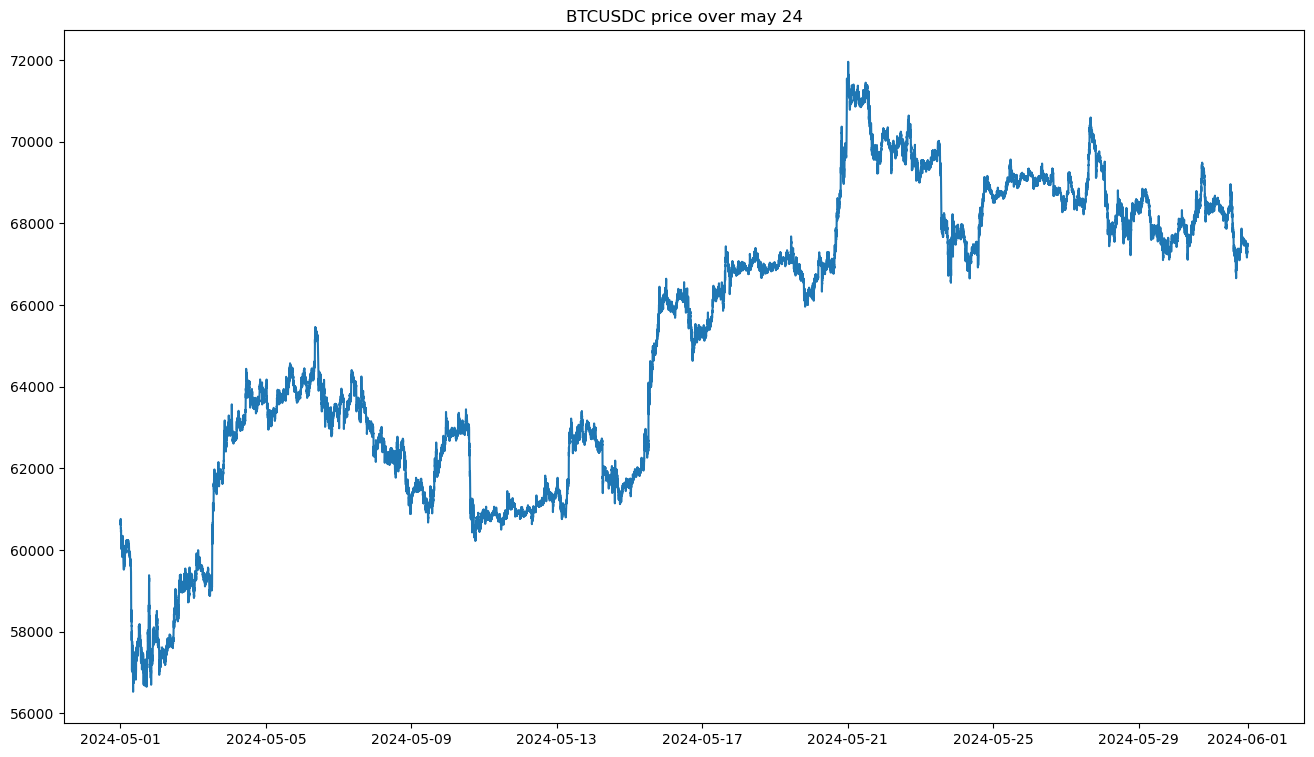

In [6]:
plt.plot(df_may.index.values, df_may['close'].values)
plt.title(pair+' price over may 24')
plt.show()

STANDARD GBM

In [7]:
df_may['log_returns'] = np.log(df_may['close'] / df_may['close'].shift(1))

trading_minutes_per_year = 365 * 24 * 60

log_return_mean = df_may['log_returns'].mean()

mu = log_return_mean * trading_minutes_per_year

log_return_variance = df_may['log_returns'].var()

vol = np.sqrt(log_return_variance * trading_minutes_per_year)

print('mu=',mu)
print('mu_daily=',mu/365)
print('sigma=',vol)
print('sigma_daily=',vol/np.sqrt(365))

mu= 1.2436524832190798
mu_daily= 0.0034072670773125477
sigma= 0.4687833717602699
sigma_daily= 0.02453724312918269


HESTON MODEL

In [8]:
import optuna
from optuna.samplers import QMCSampler, TPESampler

In [9]:
window_size = 60  # 1 hour window
df_may['rolling_std'] = df_may['log_returns'].rolling(window=window_size).std()
df_may['annualized_volatility'] = df_may['rolling_std'] * np.sqrt(trading_minutes_per_year)

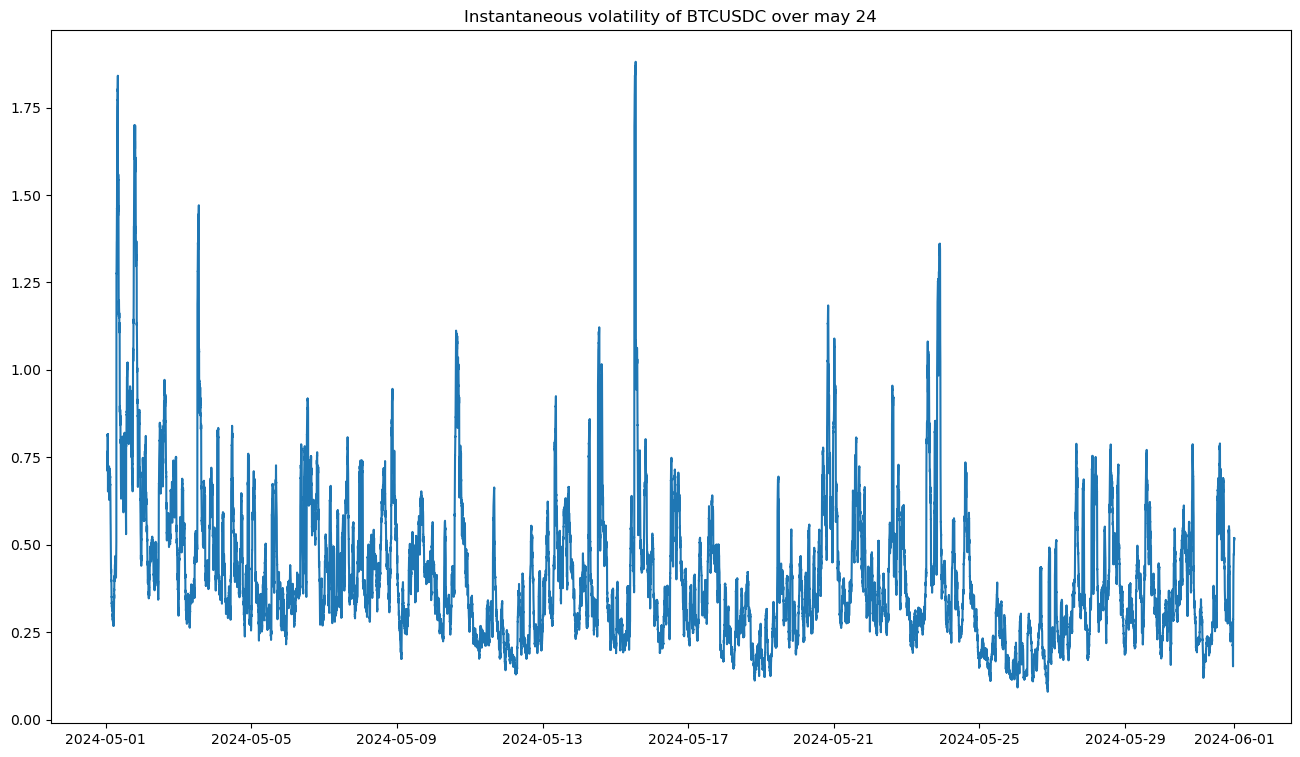

In [10]:
plt.plot(df_may.index.values, df_may['annualized_volatility'].values)
plt.title('Instantaneous volatility of '+pair+' over may 24')
plt.show()

In [11]:
from scipy.optimize import minimize

def heston_log_likelihood(params, variances, dt):
    kappa, theta, sigma = params
    log_likelihood = 0
    
    for t in range(1, len(variances)):
        vt = variances[t-1]
        vt_next = variances[t]
        mean = vt + kappa * (theta - vt) * dt
        variance = sigma**2 * vt * dt
        
        log_likelihood += -0.5 * np.log(2 * np.pi * variance) - (vt_next - mean)**2 / (2 * variance)
    
    return -log_likelihood  



In [12]:
%%time
def objective(trial):
    kappa = trial.suggest_float('kappa', 50., 10000.)
    theta = trial.suggest_float('theta', 0.01, 1.)
    sigma = trial.suggest_float('sigma', 1., 100.)
    params = kappa, theta, sigma
    
    variances = df_may.dropna()['annualized_volatility']**2
    
    dt = 1./trading_minutes_per_year
    
    return heston_log_likelihood(params, variances, dt)

study = optuna.create_study(sampler=TPESampler(seed = 0))
study.enqueue_trial({'kappa': 1000., 'theta': 0.01, 'c': 5.})
study.optimize(objective, n_trials=1000)

[I 2024-08-16 15:33:49,325] A new study created in memory with name: no-name-b23fcbd2-4d7f-418f-b73a-9d1c68e76d0a
[I 2024-08-16 15:33:49,495] Trial 0 finished with value: -112778.53670139727 and parameters: {'kappa': 1000.0, 'theta': 0.01, 'sigma': 55.33253688880515}. Best is trial 0 with value: -112778.53670139727.
[I 2024-08-16 15:33:49,664] Trial 1 finished with value: -111021.98700437717 and parameters: {'kappa': 7166.134195405574, 'theta': 0.6067357423109274, 'sigma': 54.94343511669279}. Best is trial 0 with value: -112778.53670139727.
[I 2024-08-16 15:33:49,835] Trial 2 finished with value: -118813.12382955139 and parameters: {'kappa': 4265.365253422102, 'theta': 0.6494351719359895, 'sigma': 44.321133915006556}. Best is trial 2 with value: -118813.12382955139.
[I 2024-08-16 15:33:50,005] Trial 3 finished with value: -105752.86777008913 and parameters: {'kappa': 8923.141357781693, 'theta': 0.964026132896019, 'sigma': 38.96071036375199}. Best is trial 2 with value: -118813.12382955

[I 2024-08-16 15:33:55,956] Trial 36 finished with value: -112978.73927970335 and parameters: {'kappa': 1657.688929888348, 'theta': 0.674042379021246, 'sigma': 54.84449916907462}. Best is trial 24 with value: -129857.17147189552.
[I 2024-08-16 15:33:56,140] Trial 37 finished with value: -125344.2769831901 and parameters: {'kappa': 699.7154538563418, 'theta': 0.5869649022674176, 'sigma': 36.27390218580531}. Best is trial 24 with value: -129857.17147189552.
[I 2024-08-16 15:33:56,324] Trial 38 finished with value: -34060.561298264154 and parameters: {'kappa': 497.5630251038792, 'theta': 0.849142464029597, 'sigma': 9.431488026893451}. Best is trial 24 with value: -129857.17147189552.
[I 2024-08-16 15:33:56,509] Trial 39 finished with value: -108189.33882948775 and parameters: {'kappa': 1364.023001304428, 'theta': 0.9042272282566619, 'sigma': 62.603809638202414}. Best is trial 24 with value: -129857.17147189552.
[I 2024-08-16 15:33:56,693] Trial 40 finished with value: -122904.19437950142 

[I 2024-08-16 15:34:02,352] Trial 72 finished with value: -129507.09596272618 and parameters: {'kappa': 814.3399905659296, 'theta': 0.11205048350249396, 'sigma': 27.901076072317665}. Best is trial 68 with value: -129861.36761050676.
[I 2024-08-16 15:34:02,527] Trial 73 finished with value: -127031.0444733529 and parameters: {'kappa': 2970.750185732901, 'theta': 0.02058415356187973, 'sigma': 33.378080592376676}. Best is trial 68 with value: -129861.36761050676.
[I 2024-08-16 15:34:02,703] Trial 74 finished with value: -117000.51154689991 and parameters: {'kappa': 1176.197746557784, 'theta': 0.20598347393542654, 'sigma': 16.110004356667933}. Best is trial 68 with value: -129861.36761050676.
[I 2024-08-16 15:34:02,879] Trial 75 finished with value: -126578.43352784927 and parameters: {'kappa': 699.6295141496952, 'theta': 0.14122768215525094, 'sigma': 19.811095600454248}. Best is trial 68 with value: -129861.36761050676.
[I 2024-08-16 15:34:03,055] Trial 76 finished with value: -129622.252

[I 2024-08-16 15:34:08,708] Trial 108 finished with value: -128922.41109217184 and parameters: {'kappa': 523.114283028842, 'theta': 0.14194598613433917, 'sigma': 29.63295997256522}. Best is trial 68 with value: -129861.36761050676.
[I 2024-08-16 15:34:08,883] Trial 109 finished with value: -128292.98823868526 and parameters: {'kappa': 234.12138988151364, 'theta': 0.09933722950905316, 'sigma': 21.302706728925685}. Best is trial 68 with value: -129861.36761050676.
[I 2024-08-16 15:34:09,058] Trial 110 finished with value: -125706.3156162259 and parameters: {'kappa': 691.9186992927869, 'theta': 0.06001478903390954, 'sigma': 35.71796923784194}. Best is trial 68 with value: -129861.36761050676.
[I 2024-08-16 15:34:09,232] Trial 111 finished with value: -129822.41492731187 and parameters: {'kappa': 460.86879217978117, 'theta': 0.15526957995856877, 'sigma': 26.28482500334195}. Best is trial 68 with value: -129861.36761050676.
[I 2024-08-16 15:34:09,409] Trial 112 finished with value: -129778.

[I 2024-08-16 15:34:15,096] Trial 144 finished with value: -129258.74562514566 and parameters: {'kappa': 925.4945336510691, 'theta': 0.08127537069508517, 'sigma': 28.708208960387356}. Best is trial 141 with value: -129871.56080757373.
[I 2024-08-16 15:34:15,273] Trial 145 finished with value: -129052.56608468786 and parameters: {'kappa': 1631.1624041673972, 'theta': 0.09957365030722756, 'sigma': 22.34490022670588}. Best is trial 141 with value: -129871.56080757373.
[I 2024-08-16 15:34:15,451] Trial 146 finished with value: -128036.62558943423 and parameters: {'kappa': 351.60310115239565, 'theta': 0.13532663087533045, 'sigma': 31.595719182719776}. Best is trial 141 with value: -129871.56080757373.
[I 2024-08-16 15:34:15,628] Trial 147 finished with value: -129813.10674885752 and parameters: {'kappa': 876.8151366363742, 'theta': 0.24687547201357332, 'sigma': 24.50889887678633}. Best is trial 141 with value: -129871.56080757373.
[I 2024-08-16 15:34:15,808] Trial 148 finished with value: -

[I 2024-08-16 15:34:21,379] Trial 179 finished with value: -129078.15597054963 and parameters: {'kappa': 51.444505517113974, 'theta': 0.22302052368489803, 'sigma': 22.385831073256572}. Best is trial 141 with value: -129871.56080757373.
[I 2024-08-16 15:34:21,561] Trial 180 finished with value: -128096.57587148833 and parameters: {'kappa': 1820.4683925853337, 'theta': 0.31867394091075923, 'sigma': 31.376232903793536}. Best is trial 141 with value: -129871.56080757373.
[I 2024-08-16 15:34:21,743] Trial 181 finished with value: -129863.8824444734 and parameters: {'kappa': 1064.7609585778632, 'theta': 0.29204473049086316, 'sigma': 25.319314096725233}. Best is trial 141 with value: -129871.56080757373.
[I 2024-08-16 15:34:21,926] Trial 182 finished with value: -129827.50992033567 and parameters: {'kappa': 1372.4358835197927, 'theta': 0.29375746476994136, 'sigma': 26.002331996604646}. Best is trial 141 with value: -129871.56080757373.
[I 2024-08-16 15:34:22,107] Trial 183 finished with value

[I 2024-08-16 15:34:27,655] Trial 214 finished with value: -129869.19549644094 and parameters: {'kappa': 326.17994647593923, 'theta': 0.1465754204470734, 'sigma': 25.439234616409426}. Best is trial 197 with value: -129872.99720443535.
[I 2024-08-16 15:34:27,834] Trial 215 finished with value: -129676.37127587739 and parameters: {'kappa': 301.48869061521935, 'theta': 0.17206120477756195, 'sigma': 23.834648591712615}. Best is trial 197 with value: -129872.99720443535.
[I 2024-08-16 15:34:28,013] Trial 216 finished with value: -129230.43930198062 and parameters: {'kappa': 528.1797766929903, 'theta': 0.2574822519438725, 'sigma': 28.808954606901818}. Best is trial 197 with value: -129872.99720443535.
[I 2024-08-16 15:34:28,190] Trial 217 finished with value: -128125.05387990948 and parameters: {'kappa': 265.3741974221994, 'theta': 0.2210897348796952, 'sigma': 21.11391077831561}. Best is trial 197 with value: -129872.99720443535.
[I 2024-08-16 15:34:28,367] Trial 218 finished with value: -12

[I 2024-08-16 15:34:33,897] Trial 249 finished with value: -126562.39117574581 and parameters: {'kappa': 224.36086875926955, 'theta': 0.16649912703186773, 'sigma': 19.804740666311012}. Best is trial 223 with value: -129873.37051809345.
[I 2024-08-16 15:34:34,075] Trial 250 finished with value: -129439.06476222917 and parameters: {'kappa': 53.38188384344846, 'theta': 0.13109202842395642, 'sigma': 28.126145271161455}. Best is trial 223 with value: -129873.37051809345.
[I 2024-08-16 15:34:34,253] Trial 251 finished with value: -129859.60198017082 and parameters: {'kappa': 537.2854935888927, 'theta': 0.20804400847406765, 'sigma': 25.87965500543312}. Best is trial 223 with value: -129873.37051809345.
[I 2024-08-16 15:34:34,431] Trial 252 finished with value: -129690.82803406939 and parameters: {'kappa': 779.0735842819329, 'theta': 0.1760877003332551, 'sigma': 23.870498638589947}. Best is trial 223 with value: -129873.37051809345.
[I 2024-08-16 15:34:34,610] Trial 253 finished with value: -1

[I 2024-08-16 15:34:40,128] Trial 284 finished with value: -127182.64150997765 and parameters: {'kappa': 558.1814546661287, 'theta': 0.16429564457624227, 'sigma': 33.21600887273461}. Best is trial 223 with value: -129873.37051809345.
[I 2024-08-16 15:34:40,307] Trial 285 finished with value: -128340.25169564232 and parameters: {'kappa': 300.0316669275758, 'theta': 0.13719410481826236, 'sigma': 21.353225123953138}. Best is trial 223 with value: -129873.37051809345.
[I 2024-08-16 15:34:40,486] Trial 286 finished with value: -129803.02122411996 and parameters: {'kappa': 745.5690722730742, 'theta': 0.10491860924723682, 'sigma': 26.438106245668965}. Best is trial 223 with value: -129873.37051809345.
[I 2024-08-16 15:34:40,663] Trial 287 finished with value: -129598.76246912424 and parameters: {'kappa': 476.81609036711296, 'theta': 0.06494132699114141, 'sigma': 23.57443515318168}. Best is trial 223 with value: -129873.37051809345.
[I 2024-08-16 15:34:40,841] Trial 288 finished with value: -1

[I 2024-08-16 15:34:46,338] Trial 319 finished with value: -129873.72806546828 and parameters: {'kappa': 881.4431901160511, 'theta': 0.21536478549683846, 'sigma': 25.293132297983682}. Best is trial 319 with value: -129873.72806546828.
[I 2024-08-16 15:34:46,517] Trial 320 finished with value: -128587.5750002047 and parameters: {'kappa': 757.598461664049, 'theta': 0.2181666136180225, 'sigma': 30.43524287833639}. Best is trial 319 with value: -129873.72806546828.
[I 2024-08-16 15:34:46,697] Trial 321 finished with value: -129499.03289341123 and parameters: {'kappa': 866.9609496659148, 'theta': 0.21175581925085143, 'sigma': 27.943561433027973}. Best is trial 319 with value: -129873.72806546828.
[I 2024-08-16 15:34:46,877] Trial 322 finished with value: -129872.70103141945 and parameters: {'kappa': 624.484510330464, 'theta': 0.20308806202103558, 'sigma': 25.5756406036613}. Best is trial 319 with value: -129873.72806546828.
[I 2024-08-16 15:34:47,059] Trial 323 finished with value: -128966.

[I 2024-08-16 15:34:52,606] Trial 354 finished with value: -129522.24697819579 and parameters: {'kappa': 5281.873916325748, 'theta': 0.18364942557790956, 'sigma': 26.71329907961965}. Best is trial 319 with value: -129873.72806546828.
[I 2024-08-16 15:34:52,784] Trial 355 finished with value: -129759.21222517727 and parameters: {'kappa': 217.55381027389126, 'theta': 0.1502170178959615, 'sigma': 24.217516206563126}. Best is trial 319 with value: -129873.72806546828.
[I 2024-08-16 15:34:52,961] Trial 356 finished with value: -129863.362042713 and parameters: {'kappa': 663.8171432758521, 'theta': 0.20142209687958004, 'sigma': 25.82696036023981}. Best is trial 319 with value: -129873.72806546828.
[I 2024-08-16 15:34:53,144] Trial 357 finished with value: -128189.98686954628 and parameters: {'kappa': 1104.150049290534, 'theta': 0.760288139440501, 'sigma': 21.64665820252487}. Best is trial 319 with value: -129873.72806546828.
[I 2024-08-16 15:34:53,323] Trial 358 finished with value: -129484.

[I 2024-08-16 15:34:59,036] Trial 390 finished with value: -129679.96981075115 and parameters: {'kappa': 441.6587953387391, 'theta': 0.18763192659688419, 'sigma': 23.837645646643033}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:34:59,214] Trial 391 finished with value: -129864.66600143217 and parameters: {'kappa': 621.1665812108849, 'theta': 0.1746059396928804, 'sigma': 25.780933427127362}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:34:59,393] Trial 392 finished with value: -129088.43924607793 and parameters: {'kappa': 787.8959899031604, 'theta': 0.20942922369037892, 'sigma': 29.208113925607257}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:34:59,571] Trial 393 finished with value: -129292.26895344522 and parameters: {'kappa': 1127.3453282713865, 'theta': 0.15232747591206475, 'sigma': 22.771239953057343}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:34:59,749] Trial 394 finished with value: -

[I 2024-08-16 15:35:05,455] Trial 425 finished with value: -129691.38205707197 and parameters: {'kappa': 689.5076084794582, 'theta': 0.2673801444621176, 'sigma': 23.87225443208787}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:05,638] Trial 426 finished with value: -125932.16530904177 and parameters: {'kappa': 389.86535069554895, 'theta': 0.12878931792430942, 'sigma': 19.397575613499495}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:05,821] Trial 427 finished with value: -129636.9456918462 and parameters: {'kappa': 831.6472481470404, 'theta': 0.19824798129938465, 'sigma': 27.394914372114016}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:06,024] Trial 428 finished with value: -97936.83605776548 and parameters: {'kappa': 54.811510375790476, 'theta': 0.24460800932184412, 'sigma': 81.74027905413743}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:06,208] Trial 429 finished with value: -129

[I 2024-08-16 15:35:11,943] Trial 460 finished with value: -127163.18353195567 and parameters: {'kappa': 705.0243487920527, 'theta': 0.21347655064839502, 'sigma': 33.25346604121134}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:12,128] Trial 461 finished with value: -127809.63597277281 and parameters: {'kappa': 256.0376884054211, 'theta': 0.42434957266123713, 'sigma': 20.796031034016213}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:12,312] Trial 462 finished with value: -129200.53560958932 and parameters: {'kappa': 58.8886141212933, 'theta': 0.17971777334108374, 'sigma': 28.87472420404151}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:12,499] Trial 463 finished with value: -129849.06953910778 and parameters: {'kappa': 891.4412349943736, 'theta': 0.13584167027158287, 'sigma': 26.015865035129085}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:12,685] Trial 464 finished with value: -129

[I 2024-08-16 15:35:18,730] Trial 496 finished with value: -129849.91707959327 and parameters: {'kappa': 655.7172657562137, 'theta': 0.2402968665262486, 'sigma': 26.03219042350081}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:18,920] Trial 497 finished with value: -129612.52613058257 and parameters: {'kappa': 1002.7578913440734, 'theta': 0.1486751814458337, 'sigma': 23.591253960635818}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:19,115] Trial 498 finished with value: -129569.23287998476 and parameters: {'kappa': 212.59718543479872, 'theta': 0.21879269387845154, 'sigma': 27.658372396623864}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:19,306] Trial 499 finished with value: -129868.30210570052 and parameters: {'kappa': 554.3610885948328, 'theta': 0.18823029784779202, 'sigma': 25.149030762407484}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:19,500] Trial 500 finished with value: -1

[I 2024-08-16 15:35:25,650] Trial 531 finished with value: -129072.49075843336 and parameters: {'kappa': 1195.8515461102165, 'theta': 0.15814925348779144, 'sigma': 22.35817107566708}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:25,856] Trial 532 finished with value: -129372.75435800904 and parameters: {'kappa': 397.91309004357385, 'theta': 0.1928814745296479, 'sigma': 28.366299426466558}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:26,059] Trial 533 finished with value: -129713.13115068302 and parameters: {'kappa': 789.5690008344145, 'theta': 0.24896805118381776, 'sigma': 23.96265467962409}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:26,260] Trial 534 finished with value: -129720.15405087678 and parameters: {'kappa': 594.4567912969752, 'theta': 0.14167115652990617, 'sigma': 26.977533410481794}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:26,471] Trial 535 finished with value: -1

[I 2024-08-16 15:35:32,696] Trial 566 finished with value: -129614.93636739103 and parameters: {'kappa': 594.4070407201491, 'theta': 0.20382484011464835, 'sigma': 23.596687169223532}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:32,898] Trial 567 finished with value: -129595.4922010786 and parameters: {'kappa': 957.3883288559396, 'theta': 0.23549956264761357, 'sigma': 27.566532411944493}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:33,101] Trial 568 finished with value: -129870.33551764589 and parameters: {'kappa': 324.45562127132075, 'theta': 0.18245637747450008, 'sigma': 25.440136918937803}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:33,304] Trial 569 finished with value: -129099.41127470258 and parameters: {'kappa': 550.344226280483, 'theta': 0.21369921280435306, 'sigma': 22.403187323144618}. Best is trial 386 with value: -129874.34414914512.
[I 2024-08-16 15:35:33,507] Trial 570 finished with value: -1

[I 2024-08-16 15:35:39,707] Trial 601 finished with value: -129868.39012277151 and parameters: {'kappa': 745.4214658921151, 'theta': 0.2701430272964494, 'sigma': 25.135095164707405}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:35:39,906] Trial 602 finished with value: -129333.91003360265 and parameters: {'kappa': 953.4502912343637, 'theta': 0.2215921187657154, 'sigma': 22.857541480355117}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:35:40,107] Trial 603 finished with value: -105930.34450479358 and parameters: {'kappa': 497.5914867862455, 'theta': 0.20549126640214024, 'sigma': 66.68278276125058}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:35:40,312] Trial 604 finished with value: -127086.1916488747 and parameters: {'kappa': 791.7350185984258, 'theta': 0.24261598948445345, 'sigma': 20.17791738896261}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:35:40,521] Trial 605 finished with value: -12863

[I 2024-08-16 15:35:46,817] Trial 636 finished with value: -127241.22874147989 and parameters: {'kappa': 981.790798985714, 'theta': 0.23038275497355468, 'sigma': 20.30121773927806}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:35:47,020] Trial 637 finished with value: -129853.50752515096 and parameters: {'kappa': 1265.8454317241299, 'theta': 0.25864310019468517, 'sigma': 25.814067707397772}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:35:47,222] Trial 638 finished with value: -129351.83523601257 and parameters: {'kappa': 892.0154298172257, 'theta': 0.23905307281605698, 'sigma': 22.897291363160402}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:35:47,424] Trial 639 finished with value: -129528.74328173157 and parameters: {'kappa': 912.905317036397, 'theta': 0.2055868575834067, 'sigma': 27.833512613028955}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:35:47,630] Trial 640 finished with value: -129

[I 2024-08-16 15:35:54,143] Trial 672 finished with value: -129748.22041961888 and parameters: {'kappa': 412.1774211711134, 'theta': 0.24792268471899528, 'sigma': 24.129777083438345}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:35:54,347] Trial 673 finished with value: -129693.88535457038 and parameters: {'kappa': 1348.7345535105296, 'theta': 0.11016504233091014, 'sigma': 27.100618938017927}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:35:54,551] Trial 674 finished with value: -128418.04561881907 and parameters: {'kappa': 677.9398896690922, 'theta': 0.19901278884159096, 'sigma': 21.43391768446668}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:35:54,756] Trial 675 finished with value: -128658.77178049872 and parameters: {'kappa': 995.6513058220623, 'theta': 0.22184166401609373, 'sigma': 30.271022729922347}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:35:54,963] Trial 676 finished with value: -

[I 2024-08-16 15:36:01,320] Trial 707 finished with value: -129863.0319057434 and parameters: {'kappa': 848.1771384879653, 'theta': 0.16796385964342042, 'sigma': 25.019340019192164}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:36:01,527] Trial 708 finished with value: -129622.90622892084 and parameters: {'kappa': 324.396077172132, 'theta': 0.11310203739682534, 'sigma': 27.42996657670703}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:36:01,731] Trial 709 finished with value: -127568.86803239331 and parameters: {'kappa': 746.1994191357763, 'theta': 0.23297786410318777, 'sigma': 20.57400378203707}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:36:01,934] Trial 710 finished with value: -128710.88250266302 and parameters: {'kappa': 518.5953579878583, 'theta': 0.2629604357872871, 'sigma': 30.151181610203636}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:36:02,140] Trial 711 finished with value: -12216

[I 2024-08-16 15:36:08,510] Trial 742 finished with value: -129776.54020369834 and parameters: {'kappa': 839.5654159470583, 'theta': 0.44345153091031364, 'sigma': 24.45575303212418}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:36:08,714] Trial 743 finished with value: -128911.86051093144 and parameters: {'kappa': 1058.6486682671598, 'theta': 0.11788545236557144, 'sigma': 22.10256849846519}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:36:08,917] Trial 744 finished with value: -129802.80540193211 and parameters: {'kappa': 246.67528324730858, 'theta': 0.2147855045361015, 'sigma': 26.439486698138694}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:36:09,124] Trial 745 finished with value: -126735.17370846515 and parameters: {'kappa': 616.8294738040066, 'theta': 0.16234717500501591, 'sigma': 19.920053120481384}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:36:09,332] Trial 746 finished with value: -1

[I 2024-08-16 15:36:15,776] Trial 777 finished with value: -129684.68552070907 and parameters: {'kappa': 5196.601599348132, 'theta': 0.1493463291193432, 'sigma': 25.673329968661605}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:36:15,983] Trial 778 finished with value: -128222.06663877195 and parameters: {'kappa': 8186.655687451925, 'theta': 0.1708961867404801, 'sigma': 22.363028737330477}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:36:16,188] Trial 779 finished with value: -129726.20581055588 and parameters: {'kappa': 356.0501792156567, 'theta': 0.12815811106482297, 'sigma': 26.930445275987974}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:36:16,393] Trial 780 finished with value: -128465.70453172117 and parameters: {'kappa': 506.794650296272, 'theta': 0.10360220784591784, 'sigma': 30.696745047693703}. Best is trial 570 with value: -129874.55856733731.
[I 2024-08-16 15:36:16,598] Trial 781 finished with value: -129

[I 2024-08-16 15:36:23,003] Trial 812 finished with value: -129874.93143888084 and parameters: {'kappa': 704.9792591878269, 'theta': 0.22626652616388354, 'sigma': 25.449555761561285}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:23,212] Trial 813 finished with value: -129042.40797025645 and parameters: {'kappa': 863.1381728007074, 'theta': 0.24123367085748287, 'sigma': 29.32936907994976}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:23,420] Trial 814 finished with value: -129303.23067525112 and parameters: {'kappa': 1218.967288831317, 'theta': 0.22767822332288995, 'sigma': 22.803194450907835}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:23,629] Trial 815 finished with value: -129753.7728257712 and parameters: {'kappa': 949.3824826864203, 'theta': 0.2344211031958461, 'sigma': 26.796297807561054}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:23,838] Trial 816 finished with value: -129

[I 2024-08-16 15:36:30,319] Trial 847 finished with value: -129169.623680151 and parameters: {'kappa': 1481.3549477894026, 'theta': 0.1549198660609137, 'sigma': 28.97534400089477}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:30,527] Trial 848 finished with value: -129812.57313824784 and parameters: {'kappa': 203.9198641100545, 'theta': 0.21566606300216623, 'sigma': 26.353206452116506}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:30,733] Trial 849 finished with value: -127122.28933920662 and parameters: {'kappa': 770.350857433609, 'theta': 0.1719211655008605, 'sigma': 33.32597262095388}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:30,941] Trial 850 finished with value: -129841.14613936332 and parameters: {'kappa': 487.07384973469954, 'theta': 0.24206304664812772, 'sigma': 24.74362023846381}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:31,149] Trial 851 finished with value: -126134

[I 2024-08-16 15:36:37,824] Trial 883 finished with value: -129699.71756285145 and parameters: {'kappa': 912.529096918451, 'theta': 0.687095511379783, 'sigma': 26.225679572503978}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:38,036] Trial 884 finished with value: -128083.48041598398 and parameters: {'kappa': 424.2361396488058, 'theta': 0.1956433638149198, 'sigma': 21.06761774421572}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:38,244] Trial 885 finished with value: -128787.07495816714 and parameters: {'kappa': 183.3509285036609, 'theta': 0.18996808587084177, 'sigma': 29.95979006425067}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:38,452] Trial 886 finished with value: -129854.62624951084 and parameters: {'kappa': 577.8705775456788, 'theta': 0.17515938950764187, 'sigma': 24.909376244509218}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:38,660] Trial 887 finished with value: -118741

[I 2024-08-16 15:36:45,161] Trial 918 finished with value: -129790.2698721281 and parameters: {'kappa': 1169.4947367740754, 'theta': 0.1460275914728783, 'sigma': 26.55474319032331}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:45,373] Trial 919 finished with value: -129610.20972363738 and parameters: {'kappa': 1815.0038437311657, 'theta': 0.1670174418636154, 'sigma': 23.616659021692378}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:45,580] Trial 920 finished with value: -129872.00242029366 and parameters: {'kappa': 828.2302139951931, 'theta': 0.2762773096725697, 'sigma': 25.318764717486644}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:45,791] Trial 921 finished with value: -129843.95221554994 and parameters: {'kappa': 1372.4720300849267, 'theta': 0.3018014839827611, 'sigma': 25.256783950232347}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:46,002] Trial 922 finished with value: -129

[I 2024-08-16 15:36:52,540] Trial 953 finished with value: -129559.34231601951 and parameters: {'kappa': 839.456005317439, 'theta': 0.2592904983440645, 'sigma': 27.712051554295495}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:52,752] Trial 954 finished with value: -129440.11318770167 and parameters: {'kappa': 1589.7808109979692, 'theta': 0.37151886708522264, 'sigma': 23.385321477728844}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:52,961] Trial 955 finished with value: -129859.57926268679 and parameters: {'kappa': 1071.6255405652128, 'theta': 0.20201378057418334, 'sigma': 25.881969558856166}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:53,174] Trial 956 finished with value: -109226.34950956173 and parameters: {'kappa': 649.729772827523, 'theta': 0.16594715194713947, 'sigma': 14.585275993478222}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:36:53,388] Trial 957 finished with value: -1

[I 2024-08-16 15:36:59,946] Trial 988 finished with value: -129340.59769778336 and parameters: {'kappa': 233.47404589928306, 'theta': 0.2627821802760843, 'sigma': 28.465731093222626}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:37:00,158] Trial 989 finished with value: -112380.89353342722 and parameters: {'kappa': 474.34454245760594, 'theta': 0.22598217762709483, 'sigma': 55.96687020605127}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:37:00,378] Trial 990 finished with value: -127628.19898329041 and parameters: {'kappa': 869.9182813098122, 'theta': 0.19122260504027971, 'sigma': 20.62656640028158}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:37:00,599] Trial 991 finished with value: -129870.50898172782 and parameters: {'kappa': 639.082854721014, 'theta': 0.15835776356463774, 'sigma': 25.23293758586488}. Best is trial 812 with value: -129874.93143888084.
[I 2024-08-16 15:37:00,814] Trial 992 finished with value: -128

CPU times: user 3min 12s, sys: 321 ms, total: 3min 12s
Wall time: 3min 12s


In [13]:
study.best_params

{'kappa': 704.9792591878269,
 'theta': 0.22626652616388354,
 'sigma': 25.449555761561285}

CALIBRATION ON DATA FROM JUNE 24


In [ ]:
df_06 = pd.read_csv('../data/'+pair+'/'+pair+'-1m-2024-06.csv')
df_06.columns=['time', 'open', 'high', 'low', 'close', 's1', 's2', 's3', 's4', 's5', 's6', 's7']
df_06.set_index('time', inplace=True)
df_06.index = pd.to_datetime(df_06.index, unit='ms')
df_06

,open,high,low,close,s1,s2,s3,s4,s5,s6,s7
time,,,,,,,,,,,
2024-06-01 00:01:00,67504.00,67516.00,67484.01,67497.41,0.04019,1717200119999,2712.887692,23,0.03207,2164.705585,0
2024-06-01 00:02:00,67491.99,67516.00,67490.01,67516.00,0.24421,1717200179999,16484.675529,22,0.18425,12437.925481,0
2024-06-01 00:03:00,67512.01,67555.99,67504.00,67544.88,0.60790,1717200239999,41052.057282,58,0.52674,35569.948504,0
2024-06-01 00:04:00,67532.02,67577.99,67532.02,67576.00,0.35218,1717200299999,23792.788301,28,0.27368,18488.114038,0
2024-06-01 00:05:00,67580.12,67630.50,67560.01,67572.02,0.64997,1717200359999,43937.466364,69,0.38451,25990.527152,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 23:55:00,62752.01,62759.99,62752.01,62759.98,0.31965,1719791759999,20060.619347,9,0.08063,5059.728131,0
2024-06-30 23:56:00,62754.01,62770.00,62687.59,62701.99,2.63720,1719791819999,165429.948547,105,0.79356,49792.468857,0
2024-06-30 23:57:00,62700.00,62724.00,62700.00,62710.91,1.18400,1719791879999,74257.592841,40,0.35515,22269.996154,0


In [15]:
df_june = df_06[['close']].copy()
df_june

,close
time,
2024-06-01 00:01:00,67497.41
2024-06-01 00:02:00,67516.00
2024-06-01 00:03:00,67544.88
2024-06-01 00:04:00,67576.00
2024-06-01 00:05:00,67572.02
...,...
2024-06-30 23:55:00,62759.98
2024-06-30 23:56:00,62701.99
2024-06-30 23:57:00,62710.91


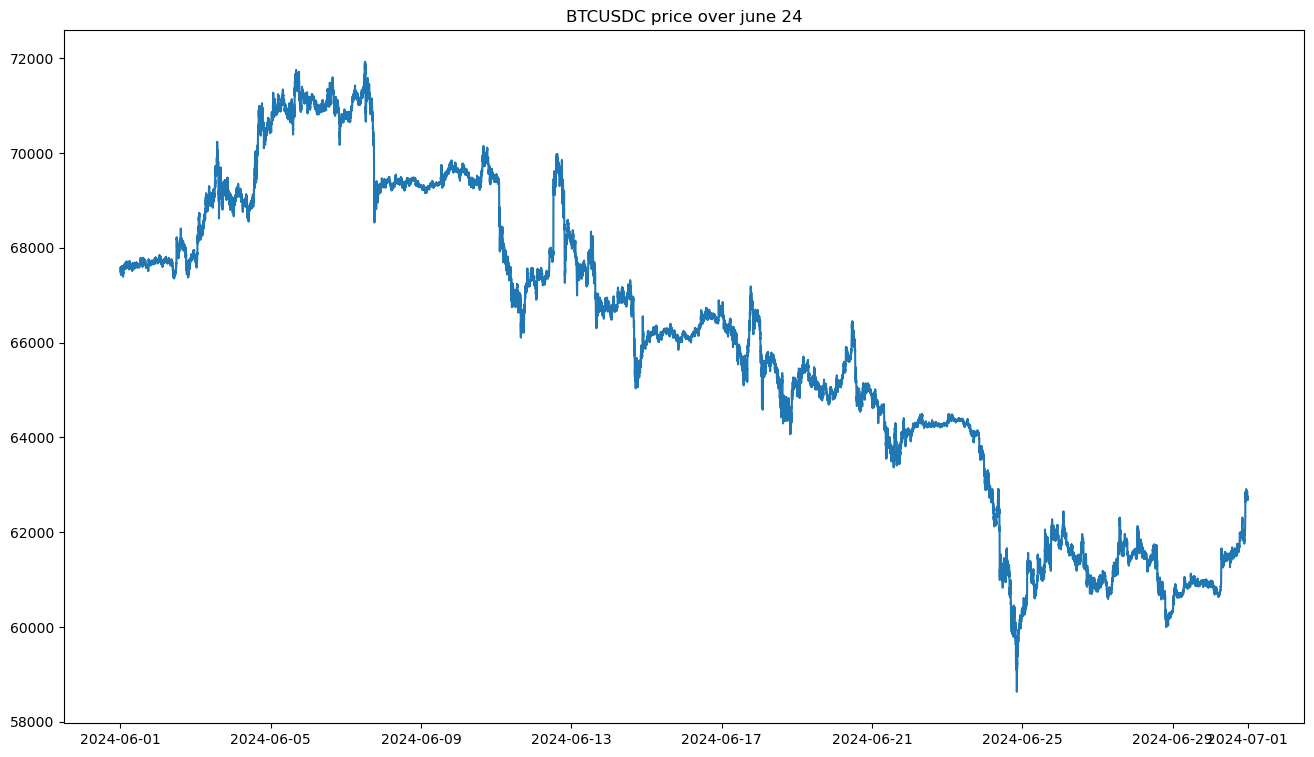

In [16]:
plt.plot(df_june.index.values, df_june['close'].values)
plt.title(pair+' price over june 24')
plt.show()

STANDARD GBM

In [17]:
df_june['log_returns'] = np.log(df_june['close'] / df_june['close'].shift(1))

trading_minutes_per_year = 365 * 24 * 60

log_return_mean = df_june['log_returns'].mean()

mu = log_return_mean * trading_minutes_per_year

log_return_variance = df_june['log_returns'].var()

vol = np.sqrt(log_return_variance * trading_minutes_per_year)

print('mu=',mu)
print('mu_daily=',mu/365)
print('sigma=',vol)
print('sigma_daily=',vol/np.sqrt(365))

mu= -0.9001681149667387
mu_daily= -0.002466214013607503
sigma= 0.3755797086775985
sigma_daily= 0.019658740436131833


HESTON MODEL

In [18]:
window_size = 60  # 1 hour window
df_june['rolling_std'] = df_june['log_returns'].rolling(window=window_size).std()
df_june['annualized_volatility'] = df_june['rolling_std'] * np.sqrt(trading_minutes_per_year)

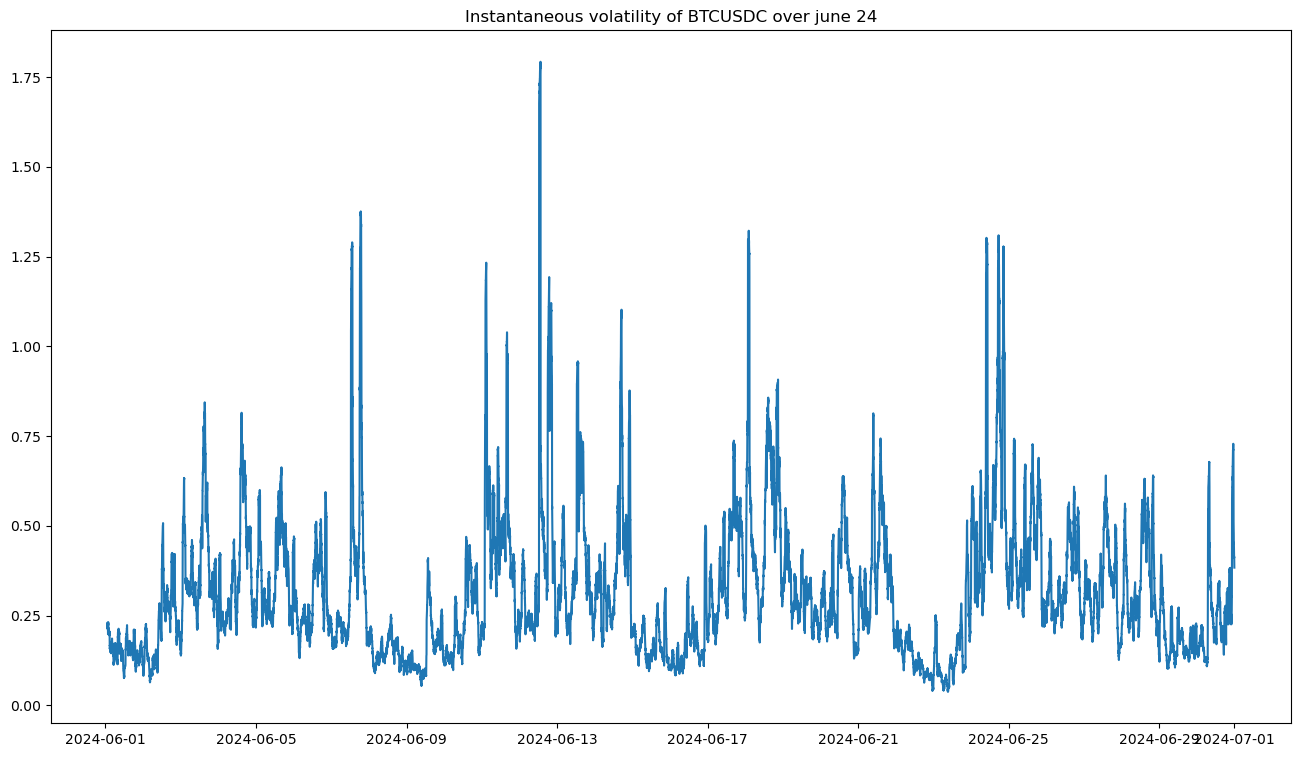

In [19]:
plt.plot(df_june.index.values, df_june['annualized_volatility'].values)
plt.title('Instantaneous volatility of '+pair+' over june 24')
plt.show()

In [20]:
%%time
def objective(trial):
    kappa = trial.suggest_float('kappa', 50., 10000.)
    theta = trial.suggest_float('theta', 0.01, 1.)
    sigma = trial.suggest_float('sigma', 1., 100.)
    params = kappa, theta, sigma
    
    variances = df_june.dropna()['annualized_volatility']**2
    
    dt = 1./trading_minutes_per_year
    
    return heston_log_likelihood(params, variances, dt)

study = optuna.create_study(sampler=TPESampler(seed = 0))
study.enqueue_trial({'kappa': 1000., 'theta': 0.01, 'c': 5.})
study.optimize(objective, n_trials=1000)

[I 2024-08-16 15:37:02,624] A new study created in memory with name: no-name-cbc79f77-5579-46e8-a37e-493243b6a3b8
[I 2024-08-16 15:37:02,817] Trial 0 finished with value: -121976.65045127839 and parameters: {'kappa': 1000.0, 'theta': 0.01, 'sigma': 55.33253688880515}. Best is trial 0 with value: -121976.65045127839.
[I 2024-08-16 15:37:03,005] Trial 1 finished with value: -116238.47306564255 and parameters: {'kappa': 7166.134195405574, 'theta': 0.6067357423109274, 'sigma': 54.94343511669279}. Best is trial 0 with value: -121976.65045127839.
[I 2024-08-16 15:37:03,197] Trial 2 finished with value: -124631.3649429807 and parameters: {'kappa': 4265.365253422102, 'theta': 0.6494351719359895, 'sigma': 44.321133915006556}. Best is trial 2 with value: -124631.3649429807.
[I 2024-08-16 15:37:03,393] Trial 3 finished with value: -82312.57853570134 and parameters: {'kappa': 8923.141357781693, 'theta': 0.964026132896019, 'sigma': 38.96071036375199}. Best is trial 2 with value: -124631.3649429807.

[I 2024-08-16 15:37:09,820] Trial 36 finished with value: -124951.8082709468 and parameters: {'kappa': 846.2550857607472, 'theta': 0.2603790159213147, 'sigma': 50.16076244584386}. Best is trial 33 with value: -134503.0583119384.
[I 2024-08-16 15:37:10,015] Trial 37 finished with value: -127565.82641188963 and parameters: {'kappa': 2474.154604223261, 'theta': 0.6024644324840535, 'sigma': 43.80857119454872}. Best is trial 33 with value: -134503.0583119384.
[I 2024-08-16 15:37:10,212] Trial 38 finished with value: -24606.862370577626 and parameters: {'kappa': 223.82933659787182, 'theta': 0.08618052915454828, 'sigma': 9.990254199331844}. Best is trial 33 with value: -134503.0583119384.
[I 2024-08-16 15:37:10,406] Trial 39 finished with value: -119672.70276435165 and parameters: {'kappa': 3014.39808415886, 'theta': 0.3827088735891701, 'sigma': 58.841014345560936}. Best is trial 33 with value: -134503.0583119384.
[I 2024-08-16 15:37:10,599] Trial 40 finished with value: -133350.55953539672 a

[I 2024-08-16 15:37:17,008] Trial 72 finished with value: -134537.2339415445 and parameters: {'kappa': 1825.0758829178358, 'theta': 0.1504893786485087, 'sigma': 27.780761853660337}. Best is trial 57 with value: -134592.8861652806.
[I 2024-08-16 15:37:17,212] Trial 73 finished with value: -129854.17661523049 and parameters: {'kappa': 1766.4384265808394, 'theta': 0.25195637029244433, 'sigma': 21.38617502339642}. Best is trial 57 with value: -134592.8861652806.
[I 2024-08-16 15:37:17,419] Trial 74 finished with value: -134577.58533491477 and parameters: {'kappa': 1281.1850311858288, 'theta': 0.159472716905772, 'sigma': 27.94514542094766}. Best is trial 57 with value: -134592.8861652806.
[I 2024-08-16 15:37:17,622] Trial 75 finished with value: -133687.94926875757 and parameters: {'kappa': 2126.8315019949955, 'theta': 0.15733401465421143, 'sigma': 33.24836386156762}. Best is trial 57 with value: -134592.8861652806.
[I 2024-08-16 15:37:17,825] Trial 76 finished with value: -133232.945661820

[I 2024-08-16 15:37:24,394] Trial 108 finished with value: -133152.01389614583 and parameters: {'kappa': 1136.435681054773, 'theta': 0.24448903235486596, 'sigma': 24.14374619287575}. Best is trial 96 with value: -134594.34255524512.
[I 2024-08-16 15:37:24,600] Trial 109 finished with value: -133680.71108493203 and parameters: {'kappa': 927.7752578241259, 'theta': 0.16637093906487532, 'sigma': 33.41213987719965}. Best is trial 96 with value: -134594.34255524512.
[I 2024-08-16 15:37:24,808] Trial 110 finished with value: -130149.97480403702 and parameters: {'kappa': 1714.289875294779, 'theta': 0.1377444841981847, 'sigma': 41.01540064937825}. Best is trial 96 with value: -134594.34255524512.
[I 2024-08-16 15:37:25,015] Trial 111 finished with value: -134506.80165284863 and parameters: {'kappa': 2495.563136044966, 'theta': 0.14060574052991362, 'sigma': 27.881427050689396}. Best is trial 96 with value: -134594.34255524512.
[I 2024-08-16 15:37:25,223] Trial 112 finished with value: -134560.3

[I 2024-08-16 15:37:31,995] Trial 144 finished with value: -133858.68918365287 and parameters: {'kappa': 1485.342971642892, 'theta': 0.08926306270242026, 'sigma': 32.87775012466252}. Best is trial 132 with value: -134617.67321727527.
[I 2024-08-16 15:37:32,219] Trial 145 finished with value: -134580.89529258225 and parameters: {'kappa': 727.0864647031302, 'theta': 0.0735631696559621, 'sigma': 29.53233453668118}. Best is trial 132 with value: -134617.67321727527.
[I 2024-08-16 15:37:32,500] Trial 146 finished with value: -134518.82362936504 and parameters: {'kappa': 769.311623118514, 'theta': 0.0705558748358957, 'sigma': 30.080023461434514}. Best is trial 132 with value: -134617.67321727527.
[I 2024-08-16 15:37:32,768] Trial 147 finished with value: -132662.99612209015 and parameters: {'kappa': 1093.990327646484, 'theta': 0.010572490904529455, 'sigma': 35.98375391083547}. Best is trial 132 with value: -134617.67321727527.
[I 2024-08-16 15:37:32,987] Trial 148 finished with value: -13414

[I 2024-08-16 15:37:40,017] Trial 179 finished with value: -132067.75794685094 and parameters: {'kappa': 1179.7472670977022, 'theta': 0.08713191499695853, 'sigma': 22.85130222099277}. Best is trial 132 with value: -134617.67321727527.
[I 2024-08-16 15:37:40,249] Trial 180 finished with value: -134372.86358171017 and parameters: {'kappa': 1399.2313636554322, 'theta': 0.1281242051588876, 'sigma': 26.628304022213833}. Best is trial 132 with value: -134617.67321727527.
[I 2024-08-16 15:37:40,478] Trial 181 finished with value: -134616.72074147474 and parameters: {'kappa': 996.2918367280569, 'theta': 0.10489786199602172, 'sigma': 28.323878801000287}. Best is trial 132 with value: -134617.67321727527.
[I 2024-08-16 15:37:40,707] Trial 182 finished with value: -134618.86203834228 and parameters: {'kappa': 1005.8103467873633, 'theta': 0.10197615727832095, 'sigma': 28.398709439865584}. Best is trial 182 with value: -134618.86203834228.
[I 2024-08-16 15:37:40,937] Trial 183 finished with value: 

[I 2024-08-16 15:37:48,164] Trial 214 finished with value: -134614.6891478467 and parameters: {'kappa': 1563.5977967627728, 'theta': 0.06295678101067759, 'sigma': 28.416860730780233}. Best is trial 182 with value: -134618.86203834228.
[I 2024-08-16 15:37:48,421] Trial 215 finished with value: -134524.71953568174 and parameters: {'kappa': 1968.9395330904429, 'theta': 0.05145522515680733, 'sigma': 27.391632336395773}. Best is trial 182 with value: -134618.86203834228.
[I 2024-08-16 15:37:48,679] Trial 216 finished with value: -134164.95524832176 and parameters: {'kappa': 1644.3137214085302, 'theta': 0.06270342268452381, 'sigma': 31.816988075902756}. Best is trial 182 with value: -134618.86203834228.
[I 2024-08-16 15:37:48,927] Trial 217 finished with value: -133484.3158698727 and parameters: {'kappa': 3678.816789153208, 'theta': 0.0971521795296433, 'sigma': 24.737477269847084}. Best is trial 182 with value: -134618.86203834228.
[I 2024-08-16 15:37:49,172] Trial 218 finished with value: -

[I 2024-08-16 15:37:56,671] Trial 249 finished with value: -134607.7634835878 and parameters: {'kappa': 848.9247329455065, 'theta': 0.014921108709319519, 'sigma': 28.19893003764821}. Best is trial 182 with value: -134618.86203834228.
[I 2024-08-16 15:37:56,917] Trial 250 finished with value: -134331.11203455002 and parameters: {'kappa': 817.5593041314257, 'theta': 0.02201608835514515, 'sigma': 26.43326336903886}. Best is trial 182 with value: -134618.86203834228.
[I 2024-08-16 15:37:57,161] Trial 251 finished with value: -113001.29872240762 and parameters: {'kappa': 595.7708823077089, 'theta': 0.04556537474526624, 'sigma': 71.9615659878178}. Best is trial 182 with value: -134618.86203834228.
[I 2024-08-16 15:37:57,408] Trial 252 finished with value: -134413.50572956575 and parameters: {'kappa': 852.1796939125045, 'theta': 0.05555913489481561, 'sigma': 30.72639380622776}. Best is trial 182 with value: -134618.86203834228.
[I 2024-08-16 15:37:57,653] Trial 253 finished with value: -13461

[I 2024-08-16 15:38:05,359] Trial 284 finished with value: -134554.91548433868 and parameters: {'kappa': 3280.863586559869, 'theta': 0.033296404456625114, 'sigma': 29.301662649019697}. Best is trial 278 with value: -134619.02734610223.
[I 2024-08-16 15:38:05,610] Trial 285 finished with value: -133454.78850282216 and parameters: {'kappa': 1400.1300774618956, 'theta': 0.08866140944190415, 'sigma': 24.49398543634}. Best is trial 278 with value: -134619.02734610223.
[I 2024-08-16 15:38:05,864] Trial 286 finished with value: -133118.83536084642 and parameters: {'kappa': 304.0361932791611, 'theta': 0.05614438639119487, 'sigma': 34.919149196240454}. Best is trial 278 with value: -134619.02734610223.
[I 2024-08-16 15:38:06,117] Trial 287 finished with value: -134261.53923710698 and parameters: {'kappa': 1647.7302830171398, 'theta': 0.12445248398263382, 'sigma': 31.378613015076017}. Best is trial 278 with value: -134619.02734610223.
[I 2024-08-16 15:38:06,374] Trial 288 finished with value: -1

[I 2024-08-16 15:38:14,414] Trial 319 finished with value: -134620.12868941625 and parameters: {'kappa': 309.4690590810552, 'theta': 0.0644328822907679, 'sigma': 28.803170499665192}. Best is trial 319 with value: -134620.12868941625.
[I 2024-08-16 15:38:14,676] Trial 320 finished with value: -134486.9970513701 and parameters: {'kappa': 356.40449633379717, 'theta': 0.06070837055268846, 'sigma': 30.295720341620147}. Best is trial 319 with value: -134620.12868941625.
[I 2024-08-16 15:38:14,940] Trial 321 finished with value: -134480.29292631452 and parameters: {'kappa': 237.70207850918342, 'theta': 0.03627344077654076, 'sigma': 27.058758231575666}. Best is trial 319 with value: -134620.12868941625.
[I 2024-08-16 15:38:15,203] Trial 322 finished with value: -134616.9122033866 and parameters: {'kappa': 98.81297394764943, 'theta': 0.07259231880351515, 'sigma': 28.897213895876476}. Best is trial 319 with value: -134620.12868941625.
[I 2024-08-16 15:38:15,466] Trial 323 finished with value: -1

[I 2024-08-16 15:38:23,984] Trial 354 finished with value: -133220.68160500156 and parameters: {'kappa': 914.0383811834644, 'theta': 0.1112613603219118, 'sigma': 24.143088702122938}. Best is trial 340 with value: -134622.15358835194.
[I 2024-08-16 15:38:24,260] Trial 355 finished with value: -132548.01121724094 and parameters: {'kappa': 684.4281166761984, 'theta': 0.07218151852009688, 'sigma': 36.254835653860454}. Best is trial 340 with value: -134622.15358835194.
[I 2024-08-16 15:38:24,535] Trial 356 finished with value: -123767.53247263984 and parameters: {'kappa': 1090.1335407047777, 'theta': 0.04352893302806643, 'sigma': 18.617068616265307}. Best is trial 340 with value: -134622.15358835194.
[I 2024-08-16 15:38:24,807] Trial 357 finished with value: -134301.70106328093 and parameters: {'kappa': 1347.0348775494324, 'theta': 0.02652329629657276, 'sigma': 31.244013412154903}. Best is trial 340 with value: -134622.15358835194.
[I 2024-08-16 15:38:25,080] Trial 358 finished with value: 

[I 2024-08-16 15:38:33,493] Trial 389 finished with value: -134006.5698895076 and parameters: {'kappa': 1167.4673647573768, 'theta': 0.024099403236266685, 'sigma': 25.529096739315246}. Best is trial 340 with value: -134622.15358835194.
[I 2024-08-16 15:38:33,767] Trial 390 finished with value: -133518.39595319578 and parameters: {'kappa': 6967.5233996998995, 'theta': 0.16048663860820866, 'sigma': 30.106600791835117}. Best is trial 340 with value: -134622.15358835194.
[I 2024-08-16 15:38:34,041] Trial 391 finished with value: -134112.5968692457 and parameters: {'kappa': 687.6349223917666, 'theta': 0.07276149944688838, 'sigma': 32.035147814743524}. Best is trial 340 with value: -134622.15358835194.
[I 2024-08-16 15:38:34,315] Trial 392 finished with value: -134482.48481071135 and parameters: {'kappa': 965.0948213784305, 'theta': 0.011108439984556162, 'sigma': 27.102052218647806}. Best is trial 340 with value: -134622.15358835194.
[I 2024-08-16 15:38:34,588] Trial 393 finished with value:

[I 2024-08-16 15:38:43,320] Trial 424 finished with value: -133733.60559413693 and parameters: {'kappa': 1198.5304545086688, 'theta': 0.03131394225963288, 'sigma': 24.966554478571723}. Best is trial 340 with value: -134622.15358835194.
[I 2024-08-16 15:38:43,602] Trial 425 finished with value: -134334.77594218912 and parameters: {'kappa': 684.4071741696453, 'theta': 0.04882059802057081, 'sigma': 31.119413696193558}. Best is trial 340 with value: -134622.15358835194.
[I 2024-08-16 15:38:43,892] Trial 426 finished with value: -131843.59187565956 and parameters: {'kappa': 249.9566174300131, 'theta': 0.9322364665540102, 'sigma': 22.70423624625984}. Best is trial 340 with value: -134622.15358835194.
[I 2024-08-16 15:38:44,179] Trial 427 finished with value: -134559.46270133305 and parameters: {'kappa': 995.6630391231795, 'theta': 0.061459805103411064, 'sigma': 27.566143100699676}. Best is trial 340 with value: -134622.15358835194.
[I 2024-08-16 15:38:44,460] Trial 428 finished with value: -

[I 2024-08-16 15:38:53,802] Trial 459 finished with value: -134547.47349516847 and parameters: {'kappa': 665.775700293118, 'theta': 0.14388998844167905, 'sigma': 29.853266039695686}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:38:54,146] Trial 460 finished with value: -134570.47361817132 and parameters: {'kappa': 57.86966672342108, 'theta': 0.11296427341289478, 'sigma': 27.666580346179337}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:38:54,448] Trial 461 finished with value: -133392.20706298994 and parameters: {'kappa': 644.0052537182171, 'theta': 0.42434957266123713, 'sigma': 24.502991108034184}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:38:54,758] Trial 462 finished with value: -134368.3623371636 and parameters: {'kappa': 397.45891918625443, 'theta': 0.09709486218808397, 'sigma': 30.964953094576448}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:38:55,061] Trial 463 finished with value: -1

[I 2024-08-16 15:39:04,253] Trial 494 finished with value: -133752.37334028876 and parameters: {'kappa': 1104.5295260306211, 'theta': 0.09242218088271417, 'sigma': 33.214003461077375}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:04,550] Trial 495 finished with value: -134435.14014937362 and parameters: {'kappa': 1511.038079153585, 'theta': 0.03492201872340606, 'sigma': 26.87181620941299}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:04,865] Trial 496 finished with value: -134590.26515954724 and parameters: {'kappa': 889.2074291325251, 'theta': 0.07581993547054437, 'sigma': 29.416744375347143}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:05,171] Trial 497 finished with value: -102271.54475790092 and parameters: {'kappa': 1196.043647607486, 'theta': 0.060214030963268134, 'sigma': 95.49056280860708}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:05,479] Trial 498 finished with value: -

[I 2024-08-16 15:39:15,590] Trial 529 finished with value: -127261.94932189741 and parameters: {'kappa': 1282.7187059897628, 'theta': 0.0701225924762944, 'sigma': 19.903577898221215}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:15,897] Trial 530 finished with value: -134247.91575907543 and parameters: {'kappa': 1938.53393239032, 'theta': 0.1521048813816348, 'sigma': 31.316651643374634}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:16,209] Trial 531 finished with value: -134499.94528221543 and parameters: {'kappa': 868.5669287978984, 'theta': 0.028030976561623858, 'sigma': 27.17929584303529}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:16,524] Trial 532 finished with value: -133055.90116813252 and parameters: {'kappa': 50.46526380135281, 'theta': 0.093001256336879, 'sigma': 23.925403805879423}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:16,849] Trial 533 finished with value: -1325

[I 2024-08-16 15:39:26,746] Trial 564 finished with value: -133823.9006230189 and parameters: {'kappa': 1018.497358210951, 'theta': 0.061430293715385643, 'sigma': 25.127275802443208}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:27,071] Trial 565 finished with value: -134457.85172112833 and parameters: {'kappa': 5253.223768497072, 'theta': 0.011265967910577053, 'sigma': 28.64389358316731}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:27,390] Trial 566 finished with value: -132141.65715968417 and parameters: {'kappa': 546.8659581056042, 'theta': 0.08829187766987409, 'sigma': 22.91670119643088}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:27,698] Trial 567 finished with value: -133654.89012777506 and parameters: {'kappa': 887.2411817238547, 'theta': 0.045000593658577524, 'sigma': 33.499010016713385}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:28,018] Trial 568 finished with value: -

[I 2024-08-16 15:39:37,555] Trial 599 finished with value: -134257.76785013173 and parameters: {'kappa': 495.2765569374929, 'theta': 0.12970347277887187, 'sigma': 26.16978311314088}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:37,847] Trial 600 finished with value: -133041.81815443633 and parameters: {'kappa': 847.0007506039656, 'theta': 0.10253299456201331, 'sigma': 35.10906965919385}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:38,142] Trial 601 finished with value: -133923.80245156033 and parameters: {'kappa': 525.6794908221749, 'theta': 0.08336929002190596, 'sigma': 32.68599197668909}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:38,437] Trial 602 finished with value: -134567.04229918466 and parameters: {'kappa': 659.0980942550261, 'theta': 0.15294467909671364, 'sigma': 29.67107924426919}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:38,730] Trial 603 finished with value: 9797.

[I 2024-08-16 15:39:48,503] Trial 634 finished with value: -134563.72577993377 and parameters: {'kappa': 1016.8659646053214, 'theta': 0.03780878189020323, 'sigma': 27.622043187061323}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:48,806] Trial 635 finished with value: -132087.7089517696 and parameters: {'kappa': 1248.6758873255478, 'theta': 0.8772003269145211, 'sigma': 35.26859057206682}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:49,113] Trial 636 finished with value: -134522.30369958776 and parameters: {'kappa': 726.8880806414152, 'theta': 0.12745277531913898, 'sigma': 30.05471695846016}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:49,415] Trial 637 finished with value: -134294.8848064726 and parameters: {'kappa': 526.1869150780756, 'theta': 0.06337513845812695, 'sigma': 26.293522708487206}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:49,705] Trial 638 finished with value: -134

[I 2024-08-16 15:39:58,808] Trial 669 finished with value: -134595.29741604906 and parameters: {'kappa': 608.3000128768772, 'theta': 0.12549725446137444, 'sigma': 27.900279881205005}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:59,095] Trial 670 finished with value: -134417.28803301035 and parameters: {'kappa': 756.0841602626523, 'theta': 0.09719557134938878, 'sigma': 30.7131801926923}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:59,382] Trial 671 finished with value: -134064.4903485061 and parameters: {'kappa': 455.61359915660194, 'theta': 0.057138796692489814, 'sigma': 25.648083810735667}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:59,667] Trial 672 finished with value: -134617.3370723852 and parameters: {'kappa': 796.1115394945936, 'theta': 0.0801172243951274, 'sigma': 28.943492135834724}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:39:59,954] Trial 673 finished with value: -133

[I 2024-08-16 15:40:08,714] Trial 704 finished with value: -118892.25702712491 and parameters: {'kappa': 436.21457321821845, 'theta': 0.14084078985872786, 'sigma': 60.823114923373694}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:40:08,996] Trial 705 finished with value: -134340.95690820392 and parameters: {'kappa': 611.6525077552943, 'theta': 0.1201489710936447, 'sigma': 26.447599418587473}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:40:09,276] Trial 706 finished with value: -134620.0813776863 and parameters: {'kappa': 265.6941917666963, 'theta': 0.20264270234155235, 'sigma': 28.877760616575664}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:40:09,556] Trial 707 finished with value: -107309.28062326851 and parameters: {'kappa': 302.298004586757, 'theta': 0.1090218105700071, 'sigma': 15.238164777866231}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:40:09,836] Trial 708 finished with value: -132

[I 2024-08-16 15:40:18,571] Trial 739 finished with value: -134350.89362357606 and parameters: {'kappa': 886.3840266365648, 'theta': 0.08995913795917952, 'sigma': 31.047396057486814}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:40:18,845] Trial 740 finished with value: -134595.58046582408 and parameters: {'kappa': 611.3253201033098, 'theta': 0.10421179249491329, 'sigma': 27.90278027631278}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:40:19,119] Trial 741 finished with value: -132633.30157068535 and parameters: {'kappa': 1076.1636006411654, 'theta': 0.15207251322941762, 'sigma': 23.435209199244383}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:40:19,394] Trial 742 finished with value: -114242.9984735061 and parameters: {'kappa': 832.1945283057521, 'theta': 0.08773359067615691, 'sigma': 69.52728487638342}. Best is trial 454 with value: -134623.37351901288.
[I 2024-08-16 15:40:19,665] Trial 743 finished with value: -13

[I 2024-08-16 15:40:28,112] Trial 774 finished with value: -134498.9308938732 and parameters: {'kappa': 424.278066896846, 'theta': 0.16625333570576484, 'sigma': 30.226375325184073}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:40:28,417] Trial 775 finished with value: -127615.67676326568 and parameters: {'kappa': 624.6743624523277, 'theta': 0.11517696821852896, 'sigma': 20.05607026016886}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:40:28,727] Trial 776 finished with value: -133901.88299404446 and parameters: {'kappa': 382.8013385161215, 'theta': 0.08429591025090052, 'sigma': 25.281025112318165}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:40:29,016] Trial 777 finished with value: -134622.1342940147 and parameters: {'kappa': 241.1126027296392, 'theta': 0.13955984272718217, 'sigma': 28.749162724998637}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:40:29,290] Trial 778 finished with value: -1327

[I 2024-08-16 15:40:37,694] Trial 809 finished with value: -134609.0109267642 and parameters: {'kappa': 248.2974443357939, 'theta': 0.16745828033356328, 'sigma': 28.101481538968553}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:40:37,963] Trial 810 finished with value: -116587.80594170436 and parameters: {'kappa': 726.1280334656471, 'theta': 0.12278513751898609, 'sigma': 65.06177813480119}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:40:38,232] Trial 811 finished with value: -134409.2948310073 and parameters: {'kappa': 454.54854940302226, 'theta': 0.06595563782749642, 'sigma': 26.717554820207155}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:40:38,501] Trial 812 finished with value: -132951.39073863326 and parameters: {'kappa': 740.645709416697, 'theta': 0.5418493481944411, 'sigma': 35.09631612849559}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:40:38,770] Trial 813 finished with value: -13406

[I 2024-08-16 15:40:47,157] Trial 844 finished with value: -134470.220679642 and parameters: {'kappa': 235.2293905881353, 'theta': 0.15409658254949998, 'sigma': 30.408843448924593}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:40:47,428] Trial 845 finished with value: -132745.2193912337 and parameters: {'kappa': 482.7362620880883, 'theta': 0.2134720178178241, 'sigma': 23.547154969654375}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:40:47,696] Trial 846 finished with value: -133554.41162103784 and parameters: {'kappa': 197.16098239144634, 'theta': 0.1346501903233468, 'sigma': 33.786485032897914}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:40:47,964] Trial 847 finished with value: -134385.2004314716 and parameters: {'kappa': 467.4193610393916, 'theta': 0.13822028917739781, 'sigma': 26.613125971862104}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:40:48,234] Trial 848 finished with value: -13462

[I 2024-08-16 15:40:56,628] Trial 879 finished with value: -132397.59001889714 and parameters: {'kappa': 8191.889371626954, 'theta': 0.17899180455214977, 'sigma': 27.433760148004964}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:40:56,897] Trial 880 finished with value: -128310.27641263751 and parameters: {'kappa': 597.1530092802159, 'theta': 0.1603424735788945, 'sigma': 20.381471856791933}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:40:57,166] Trial 881 finished with value: -134245.23870169956 and parameters: {'kappa': 232.3504384283878, 'theta': 0.15716163855575602, 'sigma': 31.519207931834927}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:40:57,434] Trial 882 finished with value: -134607.94656778313 and parameters: {'kappa': 584.4926953691677, 'theta': 0.16360037198204708, 'sigma': 29.150407191418825}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:40:57,703] Trial 883 finished with value: -1

[I 2024-08-16 15:41:06,452] Trial 915 finished with value: -134509.48231649428 and parameters: {'kappa': 215.83178014531637, 'theta': 0.8305872853240122, 'sigma': 30.010551495244744}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:41:06,724] Trial 916 finished with value: -133894.76143227692 and parameters: {'kappa': 660.0523767636736, 'theta': 0.1554214587528696, 'sigma': 32.77669168703003}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:41:06,994] Trial 917 finished with value: -134513.44478281407 and parameters: {'kappa': 409.6783501803489, 'theta': 0.2033264298750817, 'sigma': 27.232578296899998}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:41:07,265] Trial 918 finished with value: -134614.06716444952 and parameters: {'kappa': 545.1783048302418, 'theta': 0.18128701486342177, 'sigma': 29.013430591132025}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:41:07,536] Trial 919 finished with value: -134

[I 2024-08-16 15:41:15,953] Trial 950 finished with value: -134279.82156438165 and parameters: {'kappa': 755.4668965568246, 'theta': 0.22063364531443033, 'sigma': 26.28669849659459}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:41:16,229] Trial 951 finished with value: -134623.10330948074 and parameters: {'kappa': 216.60385518604582, 'theta': 0.16536800239976235, 'sigma': 28.6489187118653}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:41:16,537] Trial 952 finished with value: -132829.9840990111 and parameters: {'kappa': 240.59676077869995, 'theta': 0.14118439261316348, 'sigma': 23.643026848996666}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:41:16,838] Trial 953 finished with value: -134621.25509278546 and parameters: {'kappa': 478.6385205650794, 'theta': 0.16951852479491278, 'sigma': 28.421423240302552}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:41:17,111] Trial 954 finished with value: -12

[I 2024-08-16 15:41:25,935] Trial 986 finished with value: 64729.39462741522 and parameters: {'kappa': 386.9763462034522, 'theta': 0.13670473676614922, 'sigma': 8.001139240153709}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:41:26,211] Trial 987 finished with value: -134064.57013123302 and parameters: {'kappa': 3295.0596677388958, 'theta': 0.11633507250746078, 'sigma': 31.902421150305194}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:41:26,486] Trial 988 finished with value: -134484.18338418173 and parameters: {'kappa': 56.29458951599048, 'theta': 0.16173599468176736, 'sigma': 27.077749716711043}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:41:26,762] Trial 989 finished with value: -134595.1242342122 and parameters: {'kappa': 630.9297341953304, 'theta': 0.18861427277029416, 'sigma': 29.321015305815834}. Best is trial 761 with value: -134623.69361980175.
[I 2024-08-16 15:41:27,036] Trial 990 finished with value: -133

CPU times: user 4min 25s, sys: 490 ms, total: 4min 26s
Wall time: 4min 26s


In [21]:
study.best_params

{'kappa': 516.6067197058724,
 'theta': 0.12053452217756738,
 'sigma': 28.628610708438963}

CALIBRATION ON DATA FROM JULY 24


In [ ]:
df_07 = pd.read_csv('../data/'+pair+'/'+pair+'-1m-2024-07.csv')
df_07.columns=['time', 'open', 'high', 'low', 'close', 's1', 's2', 's3', 's4', 's5', 's6', 's7']
df_07.set_index('time', inplace=True)
df_07.index = pd.to_datetime(df_07.index, unit='ms')
df_07

,open,high,low,close,s1,s2,s3,s4,s5,s6,s7
time,,,,,,,,,,,
2024-07-01 00:01:00,62684.00,62697.63,62676.00,62676.00,0.57786,1719792119999,36228.747885,19,0.01560,977.954660,0
2024-07-01 00:02:00,62676.01,62680.01,62673.19,62673.19,1.35729,1719792179999,85069.833253,31,0.55657,34883.615300,0
2024-07-01 00:03:00,62671.48,62695.98,62656.00,62658.00,1.52736,1719792239999,95721.922895,43,0.58054,36383.338981,0
2024-07-01 00:04:00,62656.01,62656.02,62629.04,62637.99,0.97516,1719792299999,61089.040964,30,0.08156,5108.784345,0
2024-07-01 00:05:00,62635.01,62708.64,62635.01,62690.47,1.70787,1719792359999,107011.482468,45,1.58463,99284.251206,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 23:55:00,64668.01,64668.01,64664.01,64665.12,0.07360,1722470159999,4759.389735,9,0.04805,3107.148696,0
2024-07-31 23:56:00,64665.12,64674.01,64660.01,64674.01,0.23081,1722470219999,14925.576283,73,0.19390,12538.840467,0
2024-07-31 23:57:00,64674.00,64674.00,64650.29,64654.00,2.89024,1722470279999,186872.896466,93,0.19077,12333.888962,0


In [23]:
df_july = df_07[['close']].copy()
df_july

,close
time,
2024-07-01 00:01:00,62676.00
2024-07-01 00:02:00,62673.19
2024-07-01 00:03:00,62658.00
2024-07-01 00:04:00,62637.99
2024-07-01 00:05:00,62690.47
...,...
2024-07-31 23:55:00,64665.12
2024-07-31 23:56:00,64674.01
2024-07-31 23:57:00,64654.00


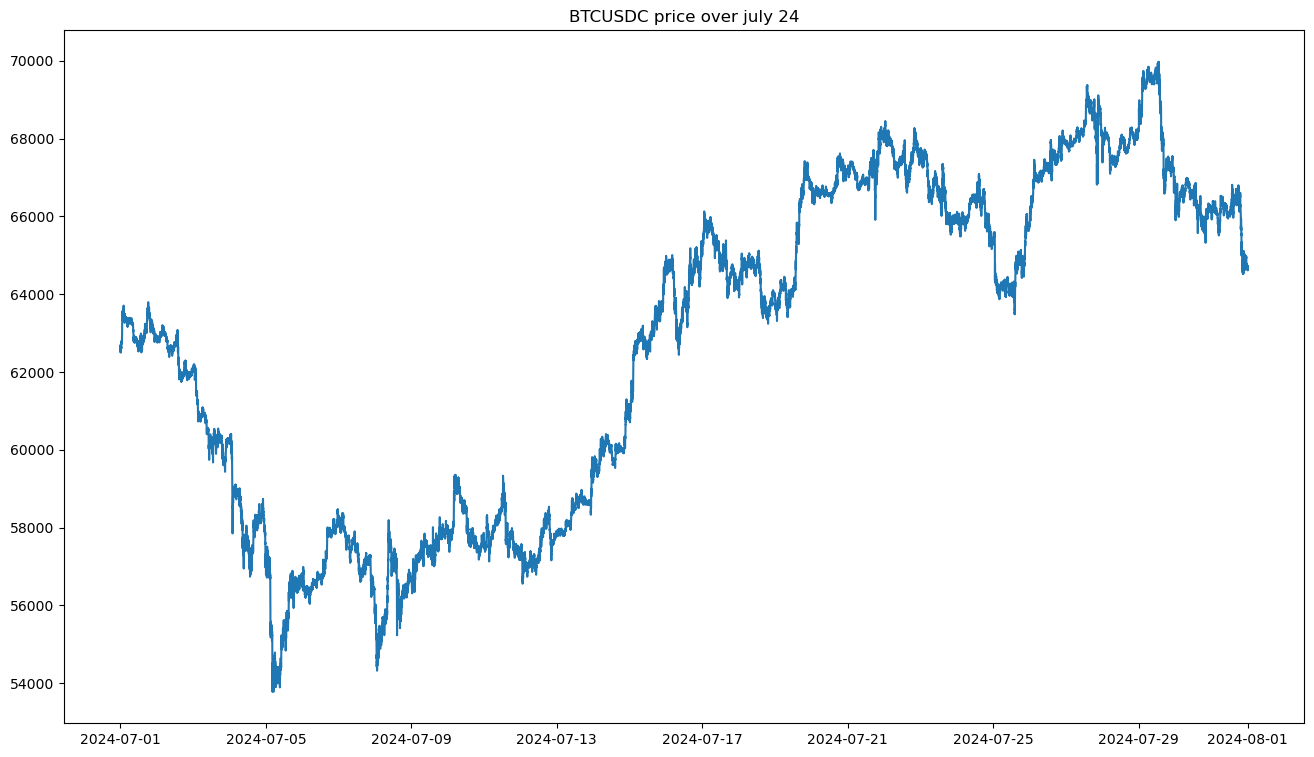

In [24]:
plt.plot(df_july.index.values, df_july['close'].values)
plt.title(pair+' price over july 24')
plt.show()

STANDARD GBM

In [25]:
df_july['log_returns'] = np.log(df_july['close'] / df_july['close'].shift(1))

trading_minutes_per_year = 365 * 24 * 60

log_return_mean = df_july['log_returns'].mean()

mu = log_return_mean * trading_minutes_per_year

log_return_variance = df_july['log_returns'].var()

vol = np.sqrt(log_return_variance * trading_minutes_per_year)

print('mu=',mu)
print('mu_daily=',mu/365)
print('sigma=',vol)
print('sigma_daily=',vol/np.sqrt(365))

mu= 0.35929867291153705
mu_daily= 0.0009843799257850331
sigma= 0.5153116679140658
sigma_daily= 0.02697264545760859


HESTON MODEL

In [26]:
window_size = 60  # 1 hour window
df_july['rolling_std'] = df_july['log_returns'].rolling(window=window_size).std()
df_july['annualized_volatility'] = df_july['rolling_std'] * np.sqrt(trading_minutes_per_year)

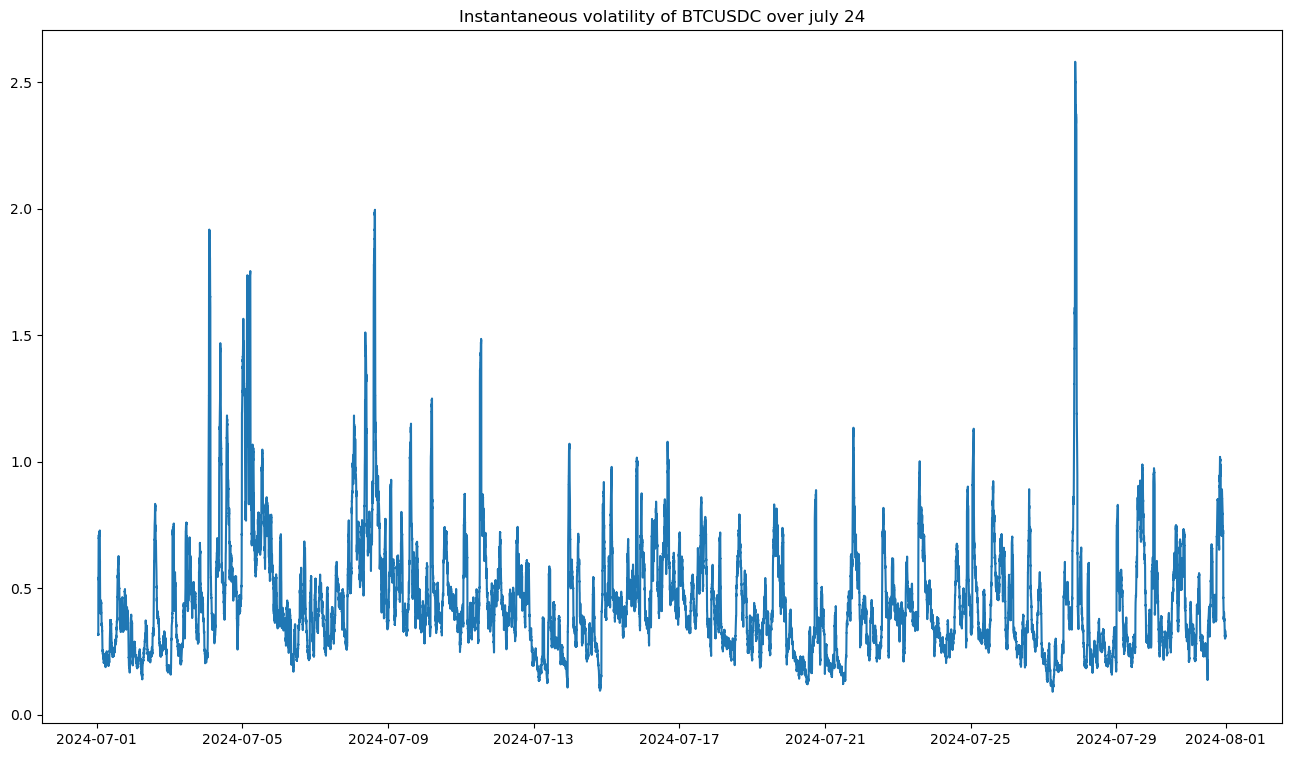

In [27]:
plt.plot(df_july.index.values, df_july['annualized_volatility'].values)
plt.title('Instantaneous volatility of '+pair+' over july 24')
plt.show()

In [28]:
%%time
def objective(trial):
    kappa = trial.suggest_float('kappa', 50., 10000.)
    theta = trial.suggest_float('theta', 0.01, 1.)
    sigma = trial.suggest_float('sigma', 1., 100.)
    params = kappa, theta, sigma
    
    variances = df_july.dropna()['annualized_volatility']**2
    
    dt = 1./trading_minutes_per_year
    
    return heston_log_likelihood(params, variances, dt)

study = optuna.create_study(sampler=TPESampler(seed = 0))
study.enqueue_trial({'kappa': 1000., 'theta': 0.01, 'c': 5.})
study.optimize(objective, n_trials=1000)

[I 2024-08-16 15:41:29,908] A new study created in memory with name: no-name-4e1f2bcb-e349-4065-926f-b52d3290abc2
[I 2024-08-16 15:41:30,172] Trial 0 finished with value: -109441.86009058286 and parameters: {'kappa': 1000.0, 'theta': 0.01, 'sigma': 55.33253688880515}. Best is trial 0 with value: -109441.86009058286.
[I 2024-08-16 15:41:30,432] Trial 1 finished with value: -108098.22954947667 and parameters: {'kappa': 7166.134195405574, 'theta': 0.6067357423109274, 'sigma': 54.94343511669279}. Best is trial 0 with value: -109441.86009058286.
[I 2024-08-16 15:41:30,691] Trial 2 finished with value: -115954.4746599851 and parameters: {'kappa': 4265.365253422102, 'theta': 0.6494351719359895, 'sigma': 44.321133915006556}. Best is trial 2 with value: -115954.4746599851.
[I 2024-08-16 15:41:30,949] Trial 3 finished with value: -106137.01091544193 and parameters: {'kappa': 8923.141357781693, 'theta': 0.964026132896019, 'sigma': 38.96071036375199}. Best is trial 2 with value: -115954.4746599851

[I 2024-08-16 15:41:39,919] Trial 36 finished with value: -109242.84655071581 and parameters: {'kappa': 3157.1841335463914, 'theta': 0.7006629500076765, 'sigma': 55.02927468963347}. Best is trial 17 with value: -127948.77550488104.
[I 2024-08-16 15:41:40,191] Trial 37 finished with value: -115901.02295407046 and parameters: {'kappa': 523.0808447129918, 'theta': 0.5529566754807208, 'sigma': 15.583088460767604}. Best is trial 17 with value: -127948.77550488104.
[I 2024-08-16 15:41:40,462] Trial 38 finished with value: -104866.65799694315 and parameters: {'kappa': 4055.7479806854244, 'theta': 0.4848949861391201, 'sigma': 62.281706211106616}. Best is trial 17 with value: -127948.77550488104.
[I 2024-08-16 15:41:40,732] Trial 39 finished with value: -127806.86445034182 and parameters: {'kappa': 1265.8190809902792, 'theta': 0.3404831573067351, 'sigma': 26.362365370526952}. Best is trial 17 with value: -127948.77550488104.
[I 2024-08-16 15:41:41,005] Trial 40 finished with value: -58309.42422

[I 2024-08-16 15:41:49,755] Trial 72 finished with value: -127968.28444374364 and parameters: {'kappa': 1825.0758829178358, 'theta': 0.380377388294896, 'sigma': 23.81938972884373}. Best is trial 71 with value: -128069.2538069983.
[I 2024-08-16 15:41:50,027] Trial 73 finished with value: -108472.56136258645 and parameters: {'kappa': 963.8103772523458, 'theta': 0.38340958458475716, 'sigma': 14.126218169131242}. Best is trial 71 with value: -128069.2538069983.
[I 2024-08-16 15:41:50,301] Trial 74 finished with value: -126851.36225030567 and parameters: {'kappa': 1689.3172490328475, 'theta': 0.42468038940896957, 'sigma': 28.850219282537637}. Best is trial 71 with value: -128069.2538069983.
[I 2024-08-16 15:41:50,572] Trial 75 finished with value: -123359.55542931377 and parameters: {'kappa': 1831.2440584328021, 'theta': 0.3480727684028813, 'sigma': 35.01026498961791}. Best is trial 71 with value: -128069.2538069983.
[I 2024-08-16 15:41:50,843] Trial 76 finished with value: -127968.01602561

[I 2024-08-16 15:41:59,474] Trial 108 finished with value: -126076.95498287711 and parameters: {'kappa': 6129.050810753899, 'theta': 0.35517640637178827, 'sigma': 22.72925203582694}. Best is trial 71 with value: -128069.2538069983.
[I 2024-08-16 15:41:59,743] Trial 109 finished with value: -118117.13436080747 and parameters: {'kappa': 814.5309987873279, 'theta': 0.6603552191277852, 'sigma': 16.208562886757363}. Best is trial 71 with value: -128069.2538069983.
[I 2024-08-16 15:42:00,012] Trial 110 finished with value: -86427.88819022964 and parameters: {'kappa': 1329.9531881140492, 'theta': 0.2517396582695271, 'sigma': 11.684285495598726}. Best is trial 71 with value: -128069.2538069983.
[I 2024-08-16 15:42:00,284] Trial 111 finished with value: -128057.99734738893 and parameters: {'kappa': 929.9688473725473, 'theta': 0.4177488469233843, 'sigma': 24.893285525007595}. Best is trial 71 with value: -128069.2538069983.
[I 2024-08-16 15:42:00,555] Trial 112 finished with value: -123924.89663

[I 2024-08-16 15:42:09,253] Trial 144 finished with value: -128009.9146289372 and parameters: {'kappa': 1722.113954838772, 'theta': 0.35971013963888465, 'sigma': 24.811650722046632}. Best is trial 116 with value: -128076.86387784575.
[I 2024-08-16 15:42:09,523] Trial 145 finished with value: -127404.69153077871 and parameters: {'kappa': 1783.7564899137367, 'theta': 0.35615350682405134, 'sigma': 21.767712050419487}. Best is trial 116 with value: -128076.86387784575.
[I 2024-08-16 15:42:09,792] Trial 146 finished with value: -125961.43666275963 and parameters: {'kappa': 1460.8929434997801, 'theta': 0.27172191690068837, 'sigma': 30.79232939087681}. Best is trial 116 with value: -128076.86387784575.
[I 2024-08-16 15:42:10,063] Trial 147 finished with value: -107167.98764527994 and parameters: {'kappa': 1969.7057130028215, 'theta': 0.2994053181931322, 'sigma': 13.94337311218047}. Best is trial 116 with value: -128076.86387784575.
[I 2024-08-16 15:42:10,332] Trial 148 finished with value: -1

[I 2024-08-16 15:42:18,976] Trial 180 finished with value: -127062.45871062233 and parameters: {'kappa': 1354.539744823039, 'theta': 0.3411403204050281, 'sigma': 28.517698271234284}. Best is trial 160 with value: -128097.1941651549.
[I 2024-08-16 15:42:19,247] Trial 181 finished with value: -128050.18556736514 and parameters: {'kappa': 1096.7378506957302, 'theta': 0.2794864983442482, 'sigma': 23.5759263463977}. Best is trial 160 with value: -128097.1941651549.
[I 2024-08-16 15:42:19,520] Trial 182 finished with value: -128029.72298900301 and parameters: {'kappa': 805.92535433015, 'theta': 0.29309193953951157, 'sigma': 23.396560822281046}. Best is trial 160 with value: -128097.1941651549.
[I 2024-08-16 15:42:19,790] Trial 183 finished with value: -127703.0301886782 and parameters: {'kappa': 1132.9135102085197, 'theta': 0.24165632231562797, 'sigma': 26.809651964201393}. Best is trial 160 with value: -128097.1941651549.
[I 2024-08-16 15:42:20,060] Trial 184 finished with value: -127111.58

[I 2024-08-16 15:42:28,755] Trial 216 finished with value: -128075.64867379374 and parameters: {'kappa': 923.352194776753, 'theta': 0.26394868341710387, 'sigma': 23.778436040654313}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:42:29,024] Trial 217 finished with value: -127845.64770735792 and parameters: {'kappa': 1259.652114492311, 'theta': 0.26078812947294017, 'sigma': 22.62420892591505}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:42:29,294] Trial 218 finished with value: -126037.52064439784 and parameters: {'kappa': 1560.1611469172976, 'theta': 0.2422665703155022, 'sigma': 19.920755953269357}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:42:29,564] Trial 219 finished with value: -128094.00506417229 and parameters: {'kappa': 964.5479030923365, 'theta': 0.1713076403659296, 'sigma': 24.110179603468143}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:42:29,833] Trial 220 finished with value: -127

[I 2024-08-16 15:42:38,286] Trial 251 finished with value: -127008.90647148572 and parameters: {'kappa': 597.6687431211059, 'theta': 0.09589870105854133, 'sigma': 28.676694283554887}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:42:38,557] Trial 252 finished with value: -127898.955370877 and parameters: {'kappa': 821.4230024071323, 'theta': 0.19748543244085515, 'sigma': 26.052810577243108}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:42:38,829] Trial 253 finished with value: -126158.58292847892 and parameters: {'kappa': 926.1641428501803, 'theta': 0.22141028186875106, 'sigma': 20.015033348539916}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:42:39,096] Trial 254 finished with value: -127994.07582510964 and parameters: {'kappa': 1315.8018284324942, 'theta': 0.12121286732326465, 'sigma': 23.24612689471763}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:42:39,366] Trial 255 finished with value: -12

[I 2024-08-16 15:42:47,694] Trial 286 finished with value: -125218.34463637837 and parameters: {'kappa': 8608.878245881378, 'theta': 0.07694162505900465, 'sigma': 20.223781332799476}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:42:47,961] Trial 287 finished with value: -127185.12328636537 and parameters: {'kappa': 7520.592459774416, 'theta': 0.2319576971370452, 'sigma': 24.769777304336806}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:42:48,228] Trial 288 finished with value: -126917.18350225645 and parameters: {'kappa': 805.3693589866325, 'theta': 0.28689471386952703, 'sigma': 28.898902557936594}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:42:48,497] Trial 289 finished with value: -127956.57377502245 and parameters: {'kappa': 1024.51286099603, 'theta': 0.1363961530429493, 'sigma': 23.037748996864167}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:42:48,764] Trial 290 finished with value: -119

[I 2024-08-16 15:42:57,329] Trial 321 finished with value: -128091.37483598421 and parameters: {'kappa': 1143.1120380724449, 'theta': 0.11937337404140136, 'sigma': 24.318874320627152}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:42:57,601] Trial 322 finished with value: -127525.5285740119 and parameters: {'kappa': 1219.9258125465572, 'theta': 0.08617148286304713, 'sigma': 21.845921088880246}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:42:57,872] Trial 323 finished with value: -128088.7548182099 and parameters: {'kappa': 908.1094787052295, 'theta': 0.10715092739839184, 'sigma': 24.15761204455291}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:42:58,144] Trial 324 finished with value: -127620.56741063819 and parameters: {'kappa': 685.3421230825312, 'theta': 0.06369600670825235, 'sigma': 27.05118956574348}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:42:58,417] Trial 325 finished with value: -12

[I 2024-08-16 15:43:06,852] Trial 356 finished with value: -125993.52382556123 and parameters: {'kappa': 675.0907943697367, 'theta': 0.1992635311668034, 'sigma': 19.865733158023737}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:43:07,125] Trial 357 finished with value: -110549.95568261601 and parameters: {'kappa': 1140.1672380911177, 'theta': 0.760288139440501, 'sigma': 53.56919539542024}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:43:07,404] Trial 358 finished with value: -107210.98248234662 and parameters: {'kappa': 886.2601219379674, 'theta': 0.12483222791411185, 'sigma': 58.83065028564722}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:43:07,690] Trial 359 finished with value: -127728.08915413482 and parameters: {'kappa': 1244.7478183821818, 'theta': 0.17888253763720546, 'sigma': 26.72068667081577}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:43:07,978] Trial 360 finished with value: -1280

[I 2024-08-16 15:43:16,857] Trial 391 finished with value: -128096.82772337171 and parameters: {'kappa': 944.4164058837827, 'theta': 0.178839377400204, 'sigma': 24.46063995738319}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:43:17,133] Trial 392 finished with value: -127680.8743888585 and parameters: {'kappa': 711.9254722718476, 'theta': 0.16994912612074298, 'sigma': 26.882643322363723}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:43:17,411] Trial 393 finished with value: -127248.61299175375 and parameters: {'kappa': 3291.4748454586042, 'theta': 0.19218128775267507, 'sigma': 21.504675210092024}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:43:17,689] Trial 394 finished with value: -126784.26707740617 and parameters: {'kappa': 910.2291964961321, 'theta': 0.1867144213652116, 'sigma': 29.187623586427755}. Best is trial 185 with value: -128097.27669356322.
[I 2024-08-16 15:43:17,967] Trial 395 finished with value: -1280

[I 2024-08-16 15:43:27,073] Trial 427 finished with value: -127342.498650019 and parameters: {'kappa': 332.75768348141617, 'theta': 0.22906367903207578, 'sigma': 21.481129653648246}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:43:27,315] Trial 428 finished with value: -128062.6740190467 and parameters: {'kappa': 1222.5761090178376, 'theta': 0.1807512849271902, 'sigma': 25.019495799735974}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:43:27,557] Trial 429 finished with value: -127043.62308353084 and parameters: {'kappa': 967.5271246866447, 'theta': 0.21499841847354664, 'sigma': 28.611755374021968}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:43:27,796] Trial 430 finished with value: -127731.95431411099 and parameters: {'kappa': 780.1996250112422, 'theta': 0.20191414875977176, 'sigma': 22.27645355115316}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:43:28,034] Trial 431 finished with value: -116

[I 2024-08-16 15:43:35,496] Trial 462 finished with value: -127129.9315094309 and parameters: {'kappa': 144.79450006532852, 'theta': 0.23498341357522978, 'sigma': 28.393027589527968}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:43:35,735] Trial 463 finished with value: -127943.79264899387 and parameters: {'kappa': 475.3302801349325, 'theta': 0.21894811747993054, 'sigma': 25.827835761835956}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:43:35,975] Trial 464 finished with value: -128054.80241043643 and parameters: {'kappa': 822.741000974371, 'theta': 0.2647230192321125, 'sigma': 23.57276207660613}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:43:36,218] Trial 465 finished with value: -127062.17057358866 and parameters: {'kappa': 1160.3341986984658, 'theta': 0.19815823791779819, 'sigma': 21.042938490075663}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:43:36,460] Trial 466 finished with value: -12

[I 2024-08-16 15:43:44,057] Trial 497 finished with value: -87965.95717936552 and parameters: {'kappa': 5273.298328481878, 'theta': 0.18856892427766092, 'sigma': 95.49056280860708}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:43:44,294] Trial 498 finished with value: -122139.31763856664 and parameters: {'kappa': 1275.0120437893818, 'theta': 0.16758893770078465, 'sigma': 17.562359060190886}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:43:44,531] Trial 499 finished with value: -127244.74805139024 and parameters: {'kappa': 572.6461866154133, 'theta': 0.2815659760896036, 'sigma': 28.12862097326028}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:43:44,766] Trial 500 finished with value: -128086.25515450996 and parameters: {'kappa': 988.9510700205868, 'theta': 0.23067615318108492, 'sigma': 23.915386582724928}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:43:45,000] Trial 501 finished with value: -126

[I 2024-08-16 15:43:52,324] Trial 532 finished with value: -114854.23393669828 and parameters: {'kappa': 1105.510920067657, 'theta': 0.7199209346533818, 'sigma': 47.21839345876489}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:43:52,559] Trial 533 finished with value: -125396.7665061966 and parameters: {'kappa': 637.6781054731368, 'theta': 0.18905081206365315, 'sigma': 31.808962501229324}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:43:52,791] Trial 534 finished with value: -127577.20886258446 and parameters: {'kappa': 937.8999624008122, 'theta': 0.12540613159875452, 'sigma': 21.930174828677703}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:43:53,025] Trial 535 finished with value: -128086.8915999563 and parameters: {'kappa': 756.3119868594298, 'theta': 0.22209796568866788, 'sigma': 24.74471387940889}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:43:53,263] Trial 536 finished with value: -12686

[I 2024-08-16 15:44:00,641] Trial 567 finished with value: -126851.68769356843 and parameters: {'kappa': 7680.724463656325, 'theta': 0.2642421124212981, 'sigma': 25.082615062210124}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:44:00,876] Trial 568 finished with value: -127072.64917978676 and parameters: {'kappa': 1437.0126187937415, 'theta': 0.2427027479160235, 'sigma': 21.071470212858905}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:44:01,111] Trial 569 finished with value: -128020.09917924875 and parameters: {'kappa': 855.1473029457852, 'theta': 0.19963174290403665, 'sigma': 23.338056559256756}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:44:01,345] Trial 570 finished with value: -123818.59400479445 and parameters: {'kappa': 1191.7175991325348, 'theta': 0.2935521278636629, 'sigma': 34.35983144250565}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:44:01,580] Trial 571 finished with value: -12

[I 2024-08-16 15:44:08,772] Trial 602 finished with value: -127967.3702827369 and parameters: {'kappa': 898.7808129125004, 'theta': 0.1718852918645784, 'sigma': 23.069915505257423}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:44:09,001] Trial 603 finished with value: -127877.55532871235 and parameters: {'kappa': 1067.555602302817, 'theta': 0.292465883921631, 'sigma': 26.131738116016376}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:44:09,230] Trial 604 finished with value: -127150.59897832951 and parameters: {'kappa': 571.0145086370395, 'theta': 0.1001497305883855, 'sigma': 21.184681112435417}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:44:09,460] Trial 605 finished with value: -127305.46568790101 and parameters: {'kappa': 834.0457694445366, 'theta': 0.23772851287458482, 'sigma': 27.974996193777297}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:44:09,691] Trial 606 finished with value: -12782

[I 2024-08-16 15:44:17,213] Trial 638 finished with value: -127031.73725678345 and parameters: {'kappa': 382.9900506989302, 'theta': 0.16928055237158113, 'sigma': 21.008943940216838}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:44:17,446] Trial 639 finished with value: -128086.7599080378 and parameters: {'kappa': 725.9553919325247, 'theta': 0.20265180716982947, 'sigma': 24.73321268162297}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:44:17,676] Trial 640 finished with value: -126740.00161927861 and parameters: {'kappa': 512.070184269294, 'theta': 0.2510241652556172, 'sigma': 29.28201781893033}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:44:17,906] Trial 641 finished with value: -124620.46734850104 and parameters: {'kappa': 794.6529476562667, 'theta': 0.2267712689757037, 'sigma': 18.839992963008452}. Best is trial 410 with value: -128098.30026016306.
[I 2024-08-16 15:44:18,140] Trial 642 finished with value: -127851

[I 2024-08-16 15:44:25,574] Trial 673 finished with value: -127624.92947416805 and parameters: {'kappa': 80.5542491579539, 'theta': 0.21669119623152155, 'sigma': 27.042261580711106}. Best is trial 659 with value: -128098.45028069644.
[I 2024-08-16 15:44:25,852] Trial 674 finished with value: -128090.91616104092 and parameters: {'kappa': 881.8838615392448, 'theta': 0.3334660688848215, 'sigma': 24.087800708230745}. Best is trial 659 with value: -128098.45028069644.
[I 2024-08-16 15:44:26,117] Trial 675 finished with value: -127404.70358029768 and parameters: {'kappa': 1149.9752319832437, 'theta': 0.2554385040474262, 'sigma': 21.58667777264461}. Best is trial 659 with value: -128098.45028069644.
[I 2024-08-16 15:44:26,363] Trial 676 finished with value: -15704.065178053343 and parameters: {'kappa': 514.513769452586, 'theta': 0.28670011104754023, 'sigma': 8.527090656915995}. Best is trial 659 with value: -128098.45028069644.
[I 2024-08-16 15:44:26,603] Trial 677 finished with value: -12796

[I 2024-08-16 15:44:33,889] Trial 708 finished with value: -127983.95245196062 and parameters: {'kappa': 858.4138589435087, 'theta': 0.2607905365790856, 'sigma': 23.137568828546783}. Best is trial 659 with value: -128098.45028069644.
[I 2024-08-16 15:44:34,118] Trial 709 finished with value: -128031.04163453233 and parameters: {'kappa': 555.9843034284675, 'theta': 0.35210534039210284, 'sigma': 25.31325911618032}. Best is trial 659 with value: -128098.45028069644.
[I 2024-08-16 15:44:34,352] Trial 710 finished with value: -125753.75689603668 and parameters: {'kappa': 680.8857855070161, 'theta': 0.20138658344667262, 'sigma': 19.659339941217414}. Best is trial 659 with value: -128098.45028069644.
[I 2024-08-16 15:44:34,586] Trial 711 finished with value: -127870.97716986189 and parameters: {'kappa': 1152.2233921378067, 'theta': 0.3094760102512137, 'sigma': 22.724078290003288}. Best is trial 659 with value: -128098.45028069644.
[I 2024-08-16 15:44:34,819] Trial 712 finished with value: -12

[I 2024-08-16 15:44:41,729] Trial 743 finished with value: -124551.2774623568 and parameters: {'kappa': 885.24690917564, 'theta': 0.2609948469205311, 'sigma': 33.21333829661927}. Best is trial 659 with value: -128098.45028069644.
[I 2024-08-16 15:44:41,921] Trial 744 finished with value: -127641.43166393731 and parameters: {'kappa': 403.4145820975408, 'theta': 0.21236874218455012, 'sigma': 22.065816748162074}. Best is trial 659 with value: -128098.45028069644.
[I 2024-08-16 15:44:42,114] Trial 745 finished with value: -124246.44265385698 and parameters: {'kappa': 1008.4605109505866, 'theta': 0.11521530470424254, 'sigma': 18.619809078466425}. Best is trial 659 with value: -128098.45028069644.
[I 2024-08-16 15:44:42,305] Trial 746 finished with value: -128086.07305914683 and parameters: {'kappa': 756.0606659914242, 'theta': 0.24073052910657813, 'sigma': 24.76420350621921}. Best is trial 659 with value: -128098.45028069644.
[I 2024-08-16 15:44:42,492] Trial 747 finished with value: -10416

[I 2024-08-16 15:44:48,398] Trial 778 finished with value: -127417.11929705132 and parameters: {'kappa': 1283.758602816586, 'theta': 0.21485027193893982, 'sigma': 27.671720819084253}. Best is trial 777 with value: -128099.04432000712.
[I 2024-08-16 15:44:48,583] Trial 779 finished with value: -126133.1204210116 and parameters: {'kappa': 956.2191986135493, 'theta': 0.24096970538516857, 'sigma': 19.991409792087623}. Best is trial 777 with value: -128099.04432000712.
[I 2024-08-16 15:44:48,768] Trial 780 finished with value: -127914.44710635218 and parameters: {'kappa': 1132.498093934896, 'theta': 0.2073298561927271, 'sigma': 25.97828192942836}. Best is trial 777 with value: -128099.04432000712.
[I 2024-08-16 15:44:48,953] Trial 781 finished with value: -128051.31429602212 and parameters: {'kappa': 1526.2864520807432, 'theta': 0.25182593389439656, 'sigma': 23.669429909982618}. Best is trial 777 with value: -128099.04432000712.
[I 2024-08-16 15:44:49,139] Trial 782 finished with value: -12

[I 2024-08-16 15:44:55,109] Trial 813 finished with value: -93643.42945565606 and parameters: {'kappa': 932.7939046970039, 'theta': 0.2532599352214011, 'sigma': 83.24949555183099}. Best is trial 777 with value: -128099.04432000712.
[I 2024-08-16 15:44:55,295] Trial 814 finished with value: -128086.13994667277 and parameters: {'kappa': 193.05312555841022, 'theta': 0.8900223279688266, 'sigma': 23.969774822161654}. Best is trial 777 with value: -128099.04432000712.
[I 2024-08-16 15:44:55,481] Trial 815 finished with value: -123710.04402848436 and parameters: {'kappa': 675.0975412725544, 'theta': 0.2769366315085829, 'sigma': 34.53456589894096}. Best is trial 777 with value: -128099.04432000712.
[I 2024-08-16 15:44:55,667] Trial 816 finished with value: -127565.01337221937 and parameters: {'kappa': 1241.9467570874135, 'theta': 0.23746338845304948, 'sigma': 27.24667506628373}. Best is trial 777 with value: -128099.04432000712.
[I 2024-08-16 15:44:55,852] Trial 817 finished with value: -12241

[I 2024-08-16 15:45:01,757] Trial 848 finished with value: -128009.2418832339 and parameters: {'kappa': 1344.2677901613868, 'theta': 0.2352902186584901, 'sigma': 25.430986625047442}. Best is trial 824 with value: -128099.46769291011.
[I 2024-08-16 15:45:01,947] Trial 849 finished with value: -125168.42094281226 and parameters: {'kappa': 1659.417381638682, 'theta': 0.2666526828849344, 'sigma': 32.1771868931304}. Best is trial 824 with value: -128099.46769291011.
[I 2024-08-16 15:45:02,135] Trial 850 finished with value: -127511.68445573746 and parameters: {'kappa': 1154.4792374998278, 'theta': 0.2389344549494496, 'sigma': 27.407617365544695}. Best is trial 824 with value: -128099.46769291011.
[I 2024-08-16 15:45:02,321] Trial 851 finished with value: -128053.99419740133 and parameters: {'kappa': 1166.630877651242, 'theta': 0.2191869960325426, 'sigma': 23.584080998551432}. Best is trial 824 with value: -128099.46769291011.
[I 2024-08-16 15:45:02,507] Trial 852 finished with value: -12492

[I 2024-08-16 15:45:08,321] Trial 883 finished with value: -128058.38034448186 and parameters: {'kappa': 610.7578139485483, 'theta': 0.2034351424181379, 'sigma': 23.620674808911744}. Best is trial 866 with value: -128099.91358722407.
[I 2024-08-16 15:45:08,509] Trial 884 finished with value: -128034.90937704737 and parameters: {'kappa': 946.893735420751, 'theta': 0.22887132906829127, 'sigma': 25.284661598748563}. Best is trial 866 with value: -128099.91358722407.
[I 2024-08-16 15:45:08,697] Trial 885 finished with value: -127695.74779844217 and parameters: {'kappa': 276.59129213204966, 'theta': 0.28504750238642085, 'sigma': 22.19643454286637}. Best is trial 866 with value: -128099.91358722407.
[I 2024-08-16 15:45:08,884] Trial 886 finished with value: -120424.17991675924 and parameters: {'kappa': 470.1143028537673, 'theta': 0.24098026163163336, 'sigma': 16.894958950554155}. Best is trial 866 with value: -128099.91358722407.
[I 2024-08-16 15:45:09,070] Trial 887 finished with value: -12

[I 2024-08-16 15:45:15,106] Trial 918 finished with value: -125704.7462150172 and parameters: {'kappa': 152.25341231774829, 'theta': 0.20759023828889778, 'sigma': 19.62935113561579}. Best is trial 866 with value: -128099.91358722407.
[I 2024-08-16 15:45:15,299] Trial 919 finished with value: -127153.48985115644 and parameters: {'kappa': 721.7347865403271, 'theta': 0.23660029023485202, 'sigma': 28.352935447259455}. Best is trial 866 with value: -128099.91358722407.
[I 2024-08-16 15:45:15,492] Trial 920 finished with value: -125620.19845868213 and parameters: {'kappa': 373.8552310643116, 'theta': 0.2594323616493206, 'sigma': 31.41946963899423}. Best is trial 866 with value: -128099.91358722407.
[I 2024-08-16 15:45:15,687] Trial 921 finished with value: -127765.22146326238 and parameters: {'kappa': 886.176806623248, 'theta': 0.19493630508725449, 'sigma': 26.59456947162203}. Best is trial 866 with value: -128099.91358722407.
[I 2024-08-16 15:45:15,880] Trial 922 finished with value: -12786

[I 2024-08-16 15:45:21,992] Trial 953 finished with value: -125583.71623453891 and parameters: {'kappa': 462.90512841935, 'theta': 0.2806085547879571, 'sigma': 31.48564268584077}. Best is trial 866 with value: -128099.91358722407.
[I 2024-08-16 15:45:22,182] Trial 954 finished with value: -127097.7268525727 and parameters: {'kappa': 659.0435300844204, 'theta': 0.31885343492613155, 'sigma': 21.09000635394946}. Best is trial 866 with value: -128099.91358722407.
[I 2024-08-16 15:45:22,372] Trial 955 finished with value: -127769.64880377747 and parameters: {'kappa': 346.05174814707516, 'theta': 0.2648009392326322, 'sigma': 26.569968512380935}. Best is trial 866 with value: -128099.91358722407.
[I 2024-08-16 15:45:22,566] Trial 956 finished with value: -98853.82542023556 and parameters: {'kappa': 729.230045268865, 'theta': 0.41355782448072587, 'sigma': 73.1357300758215}. Best is trial 866 with value: -128099.91358722407.
[I 2024-08-16 15:45:22,759] Trial 957 finished with value: -127340.548

[I 2024-08-16 15:45:28,950] Trial 989 finished with value: -128057.16698676007 and parameters: {'kappa': 808.0042342607237, 'theta': 0.2647205711069924, 'sigma': 25.10139335634976}. Best is trial 866 with value: -128099.91358722407.
[I 2024-08-16 15:45:29,145] Trial 990 finished with value: -127301.30430083336 and parameters: {'kappa': 1083.9420460903436, 'theta': 0.23881660916188857, 'sigma': 27.982384520555016}. Best is trial 866 with value: -128099.91358722407.
[I 2024-08-16 15:45:29,340] Trial 991 finished with value: -128023.54143943246 and parameters: {'kappa': 402.8073074707047, 'theta': 0.25633262925346434, 'sigma': 23.3728730842038}. Best is trial 866 with value: -128099.91358722407.
[I 2024-08-16 15:45:29,536] Trial 992 finished with value: 28863.848368451603 and parameters: {'kappa': 660.3094871529206, 'theta': 0.28633584245683535, 'sigma': 7.5498926092228515}. Best is trial 866 with value: -128099.91358722407.
[I 2024-08-16 15:45:29,732] Trial 993 finished with value: -1275

CPU times: user 4min, sys: 362 ms, total: 4min
Wall time: 4min


In [29]:
study.best_params

{'kappa': 668.0143017961796,
 'theta': 0.2555228357372921,
 'sigma': 24.295817371689015}